# Chapter 3: Spark RDD

* Last updated 202410_202310_202009_201910_201812_201712_201705_201611

Spark를 시작하기 위해서는 그 진입점 SparkSession를 생성해야 한다. 그로부터 RDD를 파일, JSON 등에서 읽어서 생성할 수 있다. 낯선 단어 RDD는 비구조적인 데이터에 보다 적합하고, 많이 쓰이는 Map-Reduce 등 RDD API를 사용하여 데이터를 변환하고, 분석할 수 있다. 텍스트를 단어 빈도, word vector로 변환해보기로 한다.

* 3.1 Spark 시작하기: 완전설치한 경우, PIP설치한 경우로 구분하여 설명
* 3.2 Spark 설정
* 3.3 데이터 구조: RDD, 데이터프레임
* 3.4 RDD 소개
* 3.5 RDD 생성: 파일, json 등에서 생성하기
* 3.6 RDD API, Pair RDD
* 3.7 spark-submit

## 3.1 Spark 시작하기

### 3.1.1 SparkSession이 뭐지

SparkSession은 Apache Spark 버전 2.0부터 도입된 애플리케이션의 진입점으로, 이전에 사용되던 SparkContext, SQLContext, HiveContext 등을 하나로 통합한 객체이다.
이를 통해 다음 작업을 위한 API를 단일 진입점에서 편리하게 사용할 수 있다.

- 클러스터와의 인터페이스: Spark 클러스터에 접속하는 클라이언트 역할을 한다. 클러스터 매니저(YARN, Mesos, Kubernetes 등)와 통신해 작업을 스케줄링한다.
- 데이터 처리 및 분석: DataFrame API를 사용하거나, SQL 쿼리를 실행하고, RDD 변환과 같은 작업을 제공한다.
- 자원 관리: 클러스터 매니저(YARN, Mesos 등)로부터 CPU, 메모리와 같은 자원을 배분받아 작업을 수행한다. SparkSession을 사용하면 클러스터 매니저와 효율적으로 통합되어 자원 할당이 자동화된다.

참고로 Spark 2.0 이전에는 아래 코드에서 보듯이 SparkContext를 먼저 만들고 이를 통해 다른 SQLContext, HiveContext를 사용했다. 이런 방식은 2.x에서도 호환되므로 그대로 사용할 수도 있지만, **SparkSession으로 통합**되었다.

```python
# Spark 버전 1.x에서는 SparkSession이 진입점이 아니었다
import pyspark
conf=pyspark.SparkConf()
conf = pyspark.SparkConf().setAppName("myAppName")
sc = pyspark.SparkContext(conf=conf)  #SparkContext를 직접 생성한다.
sqlContext = SQLContext(sc)           #SparkContext를 넣어서 SQLContext를 생성
```


Context는 다음과 같이 RDD, DataFrame, 라이브데이터, 데이터베이스에 대해 제공되고 있다.

Context 구분 | 설명 | 사용 예
----------|----------|----------
SparkContext | RDD를 사용하는 Context | 버전 2.0부터는 SparkSession.sparkContext를 사용
StreamingContext | 트위터, Flume, TCP 소켓 등 실시간 발생하는 데이터 처리 | pyspark.streaming.StreamingContext(sparkConf, Seconds(2)) 2초마다 스트리밍 데이터를 처리
SQLContext | Spark SQL, DataFrame | 버전2부터는 spark.sql (1.x에서는 SQLContext(SparkContext))
HiveContext | HiveQL, DataFrame | 버전2부터는 spark.sql (1.x에스는 HiveContext(SparkContext))


### 3.1.2  Spark 완전설치는 경로 설정 후 SparkSession 생성하자.

완전설치한 경우에는 앞서 작성한 코드를 재사용해서 spark 객체를 생성하면 된다.


### 3.1.3 단독형 PIP pypark의 설치는 SPARK_HOME/라이브러리 설정 필요없다

pyspark를 설치하는 경우에는 Spark가 설치된 경로 SPARK_HOME, Python 라이브러리 경로 PYTHONPATH를 별도로 설정할 필요가 없이 SparkSession을 별도로 생성하면 된다.

혹시 다른 방식, 예를 들면 아파치 스파크가 제공하는 pyspark 프롬프트 또는 Databricks의 Spark Cloud를 사용하는 경우는 SparkSession을 미리 생성해 주기도 한다.

!pip install pyspark

In [ ]:
설치하고 나면 아래 출력이 발견된다. 그렇지 않으면 오류일 가능성이 크다.

Successfully built pyspark
Installing collected packages: py4j, pyspark
Successfully installed py4j-0.10.9.7 pyspark-3.5.2

#### Python 경로 설정

혹시 모르니, 특히 자신의 PC에 복수의 파이썬 2.x, 3.x 버전이 설치되어 있는 경우, 어느 버전을 사용해야 하는지 환경변수를 설정해서 실행 경로를 지정해주도록 한다.

현재 사용 중인 파이썬 인터프리터의 실행 가능한 파일 경로를 출력하고 이를 적용하면 안전하다 (파이썬 가상 환경(가상환경)을 사용하고 있는 경우에도 적용된다).

In [2]:
import sys
sys.executable

'c:\\program files\\python39\\python.exe'

#### SparkSession 생성

이제 Spark의 진입점 ```SparkSession``` 객체를 생성하기 위해 pyspark.sql 모듈의 SparkSession.builder, 즉 ```pyspark.sql.SparkSession.builder```를 사용한다.

필요한 설정은 SparkSession이 만들어지기 전에 해 두는 편이 좋다. 여기서는 설정을 별도로 하지 않고 비워 놓았다.

spark를 생성하기 전 환경변수를 설정해주는 편이 좋다고 했는데 왜 그럴까? 
```getOrCreate()```가 그런 의미이다. 이 함수는 이미 SparkSession 객체가 있으면 기존에 있는 spark 인스턴스를 가져와 쓰고, 아니면 새로운 객체를 생성하여 반환하기 때문이다.

Spark를 실행하기 전 **필수적**으로 설정하는 항목은 **master**, **appName**이다.

> 환경 설정을 변경하고자 할 때의 문제점
> 
> 기존에 만들어진 SparkSession이 있다면, 새로운 설정이 적용되지 않는다. Jupyter Notebook에서는 커널을 재시작하지 않으면 메모리에 기존 SparkSession이 남아있을 수 있다. 기존의 spark를 메모리에서 제거한 후 설정을 해야 효과가 있기 때문에, 커널 재시작을 통해 SparkSession 관련 변수를 초기화하는 것이 정확한 설정 적용을 보장한다.

In [3]:
import os, sys
import pyspark

os.environ["PYSPARK_PYTHON"]=sys.executable          # Worker가 사용할 Python 실행 파일 경로 설정 (리눅스 "/usr/bin/python3")
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable   # Driver에서도 동일한 Python 경로 설정
#os.environ['HADOOP_HOME']=os.getcwd() # 현재 디렉터리를 HADOOP_HOME으로 설정
#os.environ["PATH"] += os.path.join(os.environ['HADOOP_HOME'], 'bin') # PATH에 Hadoop 바이너리 추가

myConf=pyspark.SparkConf() # 기본 설정 객체 생성, 여기에 필요한 설정 정의
#myConf=pyspark.SparkConf().set("spark.driver.bindAddress", "127.0.0.1") 드라이버 바인딩 주소 설정
#myConf=pyspark.SparkConf().set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.13:10.1.1") 

spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

#### 코드 설명

- 코드 os.environ을 사용하기 위한 ```import os```
- 코드 sys.path를 사용하기 위한 ```import sys```
- 코드 "PYSPARK_PYTHON", "PYSPARK_DRIVER_PYTHON" 경로를 설정한다.
    * PYSPARK_PYTHON는 workers/executors가 사용하는 버전, ```sys.executable```을 적어준다.
    * PYSPARK_DRIVER_PYTHON: driver가 사용하는 버전
- 코드 os.environ['HADOOP_HOME']:  HDFS와 연동 등 필요한 경우를 위해 winutils.exe, hadoop.dll을 HADOOP_HOME\bin에 저장하고 설정한다.
- 코드 myConf=pyspark.SparkConf(): SparkConf 객체를 생성하고, 곧 이어 코드 ```.config(conf=myConf)```에 전달하면서 myConf 설정(여기서는 아무런 설정도 수행하지 않았으니, 생략해도 된다).
- 코드 ```SparkSession.builder``` 생성자를 호출하여 SparkSession을 생성한다.
- 코드 ```.master``` 함수를 사용하여 클러스터 매니저를 지정, ```local```은 Spark를 로컬에서 실행한다는 의미이다.
    (1) 분산의 경우 master URL 또는 (2) 로컬인 경우 ```local[]```라고 적어준다. 즉 local의 수는 CPU core의 수를 의미한다. 예를 들어 ```local[*]```는 가능한 최대한의  core를 사용한다는 의미이다. 예를 들어, local[5]라고 하면, core의 수가 2개라고 하더라도 데이터는 5개의 partitions로 나누어져 주어진다.
    * ```local```은 Spark를 로컬에서 실행한다는 의미이다.
    * ```local[n]```는 worker의 쓰레드를 n개로 한다는 의미. CPU core의 개수에 맞추어 설정하자.
    * ```local[*]``` 는 가능하면 가용한 모든 쓰레드를 사용한다는 의미 (Runtime.getRuntime.availableProcessors()로 그 수를 알 수 있다)
- 코드 ```.appName``` 함수를 사용하여 애플리케이션 이름을 설정하고,
- 코드 .config(conf=myConf) 설정된 SparkConf 사용
- 코드 ```.getOrCreate()``` 함수를 사용하면 (1) 이미 생성된 SparkSession이 있는 경우에는 해당 객체를 반환하고, (2) 없는 경우에는 새로운 SparkSession을 생성한다. 불필요한 중복 생성을 피하기 위해 자주 적용되는 기법이다. 이 함수는 **singleton 패턴**으로 한 번에 하나의 세션만이 존재하도록 한다.

실행하면 단말 또는 명령프롬프트에 로그가 출력이 되고 있는데, 이 메시지를 읽고 상태를 파악하는 것은 좋은 습관이며 꼭 해야 한다.

(1) PYSPARK_DRIVER_PYTHON or PYSPARK_PYTHON를 설정해 주어야 한다.
(2) winutils.exe가 없다는 'WARN' (오류가 아니라서 다행이다), 메시지 출력에서 요청하는 HADOOP_HOME을 생성하고 그 파일을 저장해 놓자.

```
The system cannot find the path specified.
Missing Python executable 'c:\program files\python39\python.exe', defaulting to 'C:\Users\jsl\AppData\Roaming\Python\Python39\site-packages\pyspark\bin\..' for SPARK_HOME environment variable. Please install Python or specify the correct Python executable in PYSPARK_DRIVER_PYTHON or PYSPARK_PYTHON environment variable to detect SPARK_HOME safely.

23/08/31 15:25:47 WARN Shell: Did not find winutils.exe: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
...
```

#### 오류

주피터 노트북을 열어놓고 작업하다 컴퓨터를 대기모드로 두면서 세션이 끊기거나 하는 등의 이유로, 멀쩡히 작동하던 SparkSession을 다시 생성하려면 오류가 발생할 수 있다. 그러면 주피터 노트북의 Kernel을 재시작하면 해결된다.

- ConnectionRefusedError: [WinError 10061] 네트워크 연결을 시도하는 동안 발생한 오류, Kernel을 재시작해보자.
- ```Java gateway process exited before sending its port number``` Python과 Java 간의 통신을 위해 사용하는 Java Gateway 프로세스가 시작되었으나, 해당 프로세스가 포트 번호를 전송하기 전에 비정상적으로 종료되었다는 의미이다. Spark 버전에 따라 지원되는 Java 버전이 다를 수 있고, 그 때 발생할 수 있다. 코드에서는 Spark 2.2를 사용하고 있으나, 현재 훨씬 늦게 발표된 자바 20을 사용하고 있다면 당연히 발생할 수 있는 오류이다. Apache Spark 3.4.1을 사용하려면 Java 8, Java 11 중 하나를 선택하고, Python 3.6 이상의 버전을 사용하는 것이 권장한다. 

In [5]:
spark.version

'3.5.2'

In [6]:
!java -version

openjdk version "21.0.1" 2023-10-17
OpenJDK Runtime Environment (build 21.0.1+12-29)
OpenJDK 64-Bit Server VM (build 21.0.1+12-29, mixed mode, sharing)


In [7]:
!javac -version

javac 21.0.1


In [8]:
!python --version

Python 3.9.1


In [16]:
import sys
sys.version

'3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)]'

In [17]:
sys.executable

'C:\\Users\\admin\\Code\\git\\bb\\jsl\\pyds\\env3.9\\Scripts\\python.exe'

In [10]:
os.environ['PYSPARK_DRIVER_PYTHON']

'C:\\Users\\admin\\Code\\git\\bb\\jsl\\pyds\\env3.9\\Scripts\\python.exe'

In [11]:
os.environ['PYSPARK_PYTHON']

'C:\\Users\\admin\\Code\\git\\bb\\jsl\\pyds\\env3.9\\Scripts\\python.exe'

#### 오류: spark-warehouse 설정

혹시 오류가 발생, 생성되지 못할 수 있다. 그렇다면 현재 작업 디렉토리에 쓰기 권한이 없거나 해서 디렉토리가 생성되지 못할 수 있다. 디렉토리를 생성할 수 있는 권한을 확인하자.

"spark.sql.warehouse.dir"는 **SparkSQL에서 사용되는 데이터 저장 및 메타데이터 관리**를 위한 내부적으로 사용되는 디렉토리이다.

- spark-warehouse는 Spark를 실행하면 **현재 작업 디렉토리 아래 자동으로 생성**된다.

- 또는 ```/conf/hive-site.xml``` 파일에 spark.sql.warehouse.dir를 설정해도 된다.

- 또는 다음과 같이 SparkSession을 생성하기 전에 해당 설정을 구성해야 한다. (참고: hdfs 파일형식으로 ```file:///```을 추가)

```python
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config("spark.sql.warehouse.dir", "PJT_DIR/myspark-warehouse")\
    .getOrCreate()
```


spark-warehouse 디렉토리는 conf.get() 함수로 알아볼 수 있다. 다음에서 보듯이, ```usr.dir``` 밑에 spark-warehous가 만들어졌다는 의미이다.
Java Property에 따르면 ```user.dir```는 사용자 작업디렉토리, user working directory이다. ```user.home```은 홈 디렉토리이다.

In [12]:
spark.conf.get('spark.sql.warehouse.dir')

'file:/C:/Users/admin/Code/git/bb/jsl/pyds/spark-warehouse'

#### 명령어 작성하면서 점연산자 이해하기

SparkSession을 생성하는 명령어를 보면, 체인처럼 점명령어가 여럿 연결되어 있다.

명령어는 복사, 붙여넣기 식으로 하게되면 이해하지 못한다.
교재에 나와 있는 명령어를 이해하고, 안보고 혼자 힘으로 해야 한다.
코딩을 하면서 지금 무엇을 하는 것인지, 왜 이것을 하는지 알면서 해야 한다.

예를 들어:
* spark.sparkContext하면, spark를 타이핑하고, spark가 무엇인지 생각함. spark는 SparkSession을 말함.
* spark하고 점을 누르고 ```spark.```
* 점 다음에는 <TAB>키, 그러면 지원하는 명령어가 드롭다운으로 나옴.
* spark는 sparkContext를 지원한다. sparkContext는 RDD를 사용할 때 쓰는 명령어
* 그리고 spark.sparkContext. 그리고 파일을 읽으니까, textFile 이런 식으로

이런 식으로 무엇을 하는지, 왜 이렇게 하는지 이해하면서 프로그래밍 해야 한다.
그냥 쓱 명령어를 눈으로 보거나, 복붙하면 향상이 느릴 수 밖에 없다!

## 3.3 데이터 구조

Spark에서는 RDD, Dataframe, DataSet 세 가지 데이터구조를 제공하고 있다. 이 가운데 **RDD API에 대한 지원은 축소**되고 있다.
* **RDD**는 Spark 1.0부터 사용된 기본 구조이고, 이를 기반으로 다른 데이터구조가 만들어졌다. RDD는 데이터가 **비구조적**인 경우 사용하기 적합하다. 모델schema를 정하지 않고 사용할 수 있다.
* **Dataframe**은 버전 1.3에서 제공되어 많이 쓰이고 있다. 행x열의 테이블과 비슷하고, DataFrame과 DataSet은 데이터가 schema와 데이터타입을 가진 **구조적**인 경우 사용한다.
* **DataSet**은 그 후 1.6부터 제공하고 있다.

데이터구조 | 언제 Spark에 도입 | 설명
---------|---------|---------
**RDD** | 1.0 | **비구조적**, schema 정의가 필요없다, low-level
**Dataframe** | 1.3 | **구조적**, schema가 있고, 행열이 있는 SQL 테이블과 유사한 구조이다. Dataset[Row]와 같은 의미로, 타입을 강제하지 않는다.
**Dataset** | 1.6 | 자바의 Generic과 같이 Dataset[T]으로 '타잎'을 강제하는 형식이다. Scala와 Java에서 주로 사용되며, Python에서는 DataSet을 명시적으로 사용할 수 없다


* Spark의 RDD, DataFrame 모두 **immutable**이라 일단 생성되고 나면 원본을 수정할 수 없다.
* Spark의 데이터는 모두 **lazy**, 실제 transformation을 action까지 연기한다. **변환할 때마다 실제 변환이 일어나면 그 결과가 메모리에 저장되는 비효율성**을 막기 위해, **action이 실행되는 경우, 계산이 이루어지고, 실제 메모리를 사용**한다. RDD의 경우, action이 실행될 때마다 재계산이 이루어지는 것을 막기 위해 persist (or cache)함수를 사용할 수 있다.

## 3.4 RDD 소개

RDD(Resilient Distributed Dataset)는 Apache Spark에서 데이터를 표현하는 기본 구조이다.

그 줄임말에서 알 수 있듯이 **장애 복구가 가능한 분산 DataSet**이며, 다음과 같은 특성이 있다.

* 불변성: 생성후 변경할 수 없다.
* 병렬처리: RDD는 여러 파티션으로 나누어져 있으며, 각 파티션은 클러스터의 여러 노드에서 병렬로 처리된다. 파티션은 데이터를 분산 및 병렬 처리하기 위한 기본 단위이며, 개수를 설정할 수 있다.
* 장애 복구 - 
RDD 변환 연산의 로그에 따라 필요한 변환 연산을 재실행하여 누락된 데이터 파티션을 다시 생성할 수 있고, 이를 통해 작업 중단으로 인해 손실된 데이터가 복원될 수 있다.
* 타입 지정하는 데이터 구조
* 지연 연산: 변환 연산은 선언만 되고 실제로 실행되지 않고 지연된다.

RDD는 Python List, 파일, hdfs 등 다양한 자료에서 생성할 수 있고, 생성된 자료는 수정할 수 없는 read-only이다.

## S.5 RDD 생성

RDD는 **sparkContext**로부터 만들어 진다.
* 1) 이미 만들어진 배열과 같에서 읽어서 생성한다. 이 경우 parallelize() 함수를 사용하게 된다.
* 2) 또는 파일, 데이터베이스 등 외부에서 읽어서 생성할 수도 있다. textFile() 함수를 사용한다.

생성 방법 | 설명 | 함수
----------|----------|----------
내부에서 읽기 | Pytho list에서 생성 | parallelize()
외부에서 읽기 | 파일, HDFS, HBase 등 | ```textFile("mydir/")```<br>```textFile("mydir/*.txt")```<br>```textFile("mydir/*.gz")```<br>```Hadoop InputFormat```


### List에서 RDD 생성하기

```sparkContext.parallelize()``` 함수를 사용하여 Python list에서 RDD를 생성할 수 있다.

In [13]:
myList=[1,2,3,4,5,6,7]

In [14]:
myRdd1 = spark.sparkContext.parallelize(myList)

RDD를 화면에 출력하기 위해서는, collect() 또는 take(출력개수) 함수를 사용한다.

In [15]:
myRdd1.take(3) #Py4JJavaError가 나면 PSPARK_PYTHON, PYSPARK_DRIVER_PYTHON 경로 설정해야 한다. 

[1, 2, 3]

## Py4JJavaError

Py4JJavaError는 PySpark와 Python 간의 상호작용에서 발생하는 오류로, 환경 변수 설정 문제나 Spark의 초기화 과정에서 발생할 수 있다.

해결방안: PYSPARK_PYTHON 및 PYSPARK_DRIVER_PYTHON 환경 변수를 정확히 설정하고, 커널을 재시작한다. Jupyter Notebook에서 환경 변수나 경로 설정을 변경했을 때, 또는 새로운 라이브러리를 설치한 경우, 변경을 적용하려면 Jupyter Notebook의 커널을 재시작해야 한다. 그렇지 않으면, 이전 설정이 계속 유지되고 새로운 변경 사항이 반영되지 않을 수 있다. 그리고 pyspark.sql.SparkSession을 재생성하면 된다.

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


take() 또는 collect() 출력하면서 오류가 발생하는 경우에는 os.environ['PYSPARK_PYTHON'], os.environ['PYSPARK_DRIVER_PYTHON']을 설정하도록 한다.

In [18]:
spark.sparkContext.parallelize([0, 2, 3, 4, 6], 2).collect()

[0, 2, 3, 4, 6]

- L1: collect() 함수는 모든 파티션의 데이터를 수집하여 로컬의 리스트로 반환하는 액션(Action) 함수이다. 강조하자면 분산환경의 데이터를 로컬로 내려온다는 점이다. 대규모 데이터에 대해 collect()하면 메모리 부하가 걸릴 수 있으니, take() 함수를 사용하여 일부만 가져오는 편이 좋다.

> 파티션 partition

> 파티션이란 논리적인 데이터 분할, 즉 일정한 크기로 잘라놓은 데이터 뭉치이다.
따라서 RDD는 파티션으로 구성되어 있다고 할 수 있다.
파티션의 수는 원하는 숫자만큼 구성할 수 있다.
HDFS를 사용하면 블록마다 (HDFS의 블록크기는 보통 128MB) 파티션을 만든다.
이렇게 데이터를 분할해 놓으면 동시에 여러 파티션을 나누어 여러 노드/스레드에서 병렬처리가 가능해진다.

In [19]:
spark.sparkContext.parallelize([1,2,3,4,5,6,7], 2).glom().collect()

[[1, 2, 3], [4, 5, 6, 7]]

- L1: ```parallelize([1,2,3,4,5,6,7], 2)```와 같이 파티션을 2개로 분할하고, glom()은 파티션을 배열로 그룹화하는 함수이다. collect()하면 ```[[1, 2, 3], [4, 5, 6, 7]]``` 파티션 2개에 대해서 만들어진 배열 2개를 볼 수 있다. 이와 같이 glom()은 대량의 데이터에 대해 메모리 부하를 줄이기 위해 파티션 단위로 나누어 처리할 경우 유용하다.

### 파일에서 RDD 생성하기

파일에서 직접 RDD를 생성해 본다.
현재 작업 디렉토리 아래에 **'data/' 디렉토리**를 만들고 아래 파일을 생성한다.
파일 내용은 wikipedia에서 Apache spark를 검색한 후 첫 문단을 복사해서 가져 왔다.
일부러 3째줄은 한글, 4째 줄은 같은 단어를 반복해서 추가했다.

In [60]:
%%writefile data/ds_spark_wiki.txt
Wikipedia
Apache Spark is an open source cluster computing framework.
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
Apache Spark Apache Spark Apache Spark Apache Spark
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
Originally developed at the University of California, Berkeley's AMPLab,
the Spark codebase was later donated to the Apache Software Foundation,
which has maintained it since.
Spark provides an interface for programming entire clusters with
implicit data parallelism and fault-tolerance.

Overwriting data/ds_spark_wiki.txt


파일에서 RDD를 생성하기 위해서는 앞서와 같이 SparkContext를 사용한다.
파일명을 textFile() 함수 인자로 넣어서 만들어 주면 된다.

In [4]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

```first()```는 첫 데이터만 조회하는 action함수이다.
first()은 take(1)과 동일한 결과를 출력하는데, 그 이유는 first()는 내부적으로 take(1) 함수를 사용하기 때문이다.

In [62]:
myRdd2.first()

'Wikipedia'

#### RDD와 Spark Dataframe를 만드는 함수는 서로 다르다

DataFrame은 다음 장에서 배우게 되겠지만, file에서 읽는 방식이 RDD와 Dataframe이 서로 다르다.
RDD는 sparkContext.textFile(), Dataframe은 read.text()을 사용한다.

구분 | 설명
-----|-----
SparkSession.sparkContext.textFile() | **'SparkContext'를 사용하므로 RDD를 생성**한다.
SparkSession.read.text() | **DataFrame을 생성**한다.

In [63]:
import os
myDf=spark.read.text(os.path.join("data", "ds_spark_wiki.txt"))

In [64]:
print (myDf.first())

Row(value='Wikipedia')


읽고 생성된 변수 myDf의 데이터타입을 type()으로 확인하면 DataFrame이다.

In [65]:
print (type(myDf))

<class 'pyspark.sql.dataframe.DataFrame'>


#### csv에서 RDD 생성하기

csv 파일은 컴마로 구분된 데이터를 저장하고 있다. 이 파일을 읽어서 RDD를 생성해 보자.

In [66]:
%%writefile ./data/ds_spark_2cols.csv
35, 2
40, 27
12, 38
15, 31
21, 1
14, 19
46, 1
10, 34
28, 3
48, 1
16, 2
30, 3
32, 2
48, 1
31, 2
22, 1
12, 3
39, 29
19, 37
25, 2

Overwriting ./data/ds_spark_2cols.csv


파일에서 읽어 RDD를 생성할 수 있다.

In [67]:
myRdd4 = spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_2cols.csv"))

```take()```를 하면 그 결과는 리스트가 된다.
아래에서 보듯이 파일의 각 라인이 묶여서 리스트의 한 요소로 만들어진다.

In [68]:
myList=myRdd4.take(5)

print(myList)

['35, 2', '40, 27', '12, 38', '15, 31', '21, 1']


데이터가 2개씩 문자열로 묶여져 있다. 이들을 더해보자. '35, 2'를 더해서 37을 출력한다.

In [69]:
myRdd4.map(lambda x: x.split(","))\
    .map(lambda x: int(x[0])+int(x[1]))\
    .collect()

[37,
 67,
 50,
 46,
 22,
 33,
 47,
 44,
 31,
 49,
 18,
 33,
 34,
 49,
 33,
 23,
 15,
 68,
 56,
 27]

- L1: '35, 2' ---split() 하면---> '35' '2'로 분리하고 리스트 ```['35' '2']```에 담긴다.
- L2: '35' '2' ---정수 형변환---> 35 2이 되고 비로서 연산이 가능해진다.

## 문제: 파일에서 RDD 생성

다음 링크에서 파일을 읽어서 RDD를 생성하고, 5줄을 화면출력하세요.

* 1) 경기도 의정부시 인구현황 (파일명: ```경기도 의정부시_인구현황_20230731```)
https://www.data.go.kr/data/15009613/fileData.do

* 2) 제주특별자치도 서귀포시 내 연도별 65세이상 인구수 및 고령화비율, 노령화지수 현황 (파일명: ```제주특별자치도 서귀포시_고령화비율및노령화지수현황_20200623```)
https://www.data.go.kr/data/15051545/fileData.do

* 파일을 읽을 경우, 문자가 한글인지, 영어인지 어떻게 인코딩되었는지 주의해야 한다. 결과가 깨져보인다면, 왜 그런지 이유를 적어보자.

### SparkSession 생성

문제를 풀기 위해, SparkSession을 생성하고 있다. 주의! 한 번 만들어지면 메모리에서 해제되기까지는 존속하니, 세션 동안 SparkSession은 1회만 생성하면 된다. 이미 생성되어 있다면 또 할 필요가 없다는 뜻이다.

import os, sys
import pyspark

os.environ["PYSPARK_PYTHON"]=sys.executable          # 현재 사용 중인 Python 실행 파일 경로 설정 (리눅스 "/usr/bin/python3")
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable   # Driver에서도 동일한 Python 경로 설정

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

### RDD로 읽기

In [70]:
popRdd = spark.sparkContext\
    .textFile(os.path.join("data","경기도 의정부시_인구현황_20240930.csv"), use_unicode=True)

In [71]:
popRdd.take(5)

['�������,�α���(��),�α���(��),�α���(��),������(��),������(��),������(��),����,�����,������α�,���������,�����μ���,�μ���ȭ��ȣ,�����ͱ�������',
 '������1��,39567,20025,19542,8.60,4.35,4.25,102.47,23371,1.69,��\u2d75 �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30',
 '������2��,29644,14758,14886,6.44,3.21,3.23,99.14,16051,1.85,��\u2d75 �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30',
 'ȣ��1��,34059,16442,17617,7.40,3.57,3.83,93.33,15178,2.24,��\u2d75 �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30',
 'ȣ��2��,32529,15643,16886,7.07,3.40,3.67,92.64,13272,2.45,��\u2d75 �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30']

In [72]:
for i in popRdd.take(5):
    print(i)

�������,�α���(��),�α���(��),�α���(��),������(��),������(��),������(��),����,�����,������α�,���������,�����μ���,�μ���ȭ��ȣ,�����ͱ�������
������1��,39567,20025,19542,8.60,4.35,4.25,102.47,23371,1.69,��⵵ �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30
������2��,29644,14758,14886,6.44,3.21,3.23,99.14,16051,1.85,��⵵ �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30
ȣ��1��,34059,16442,17617,7.40,3.57,3.83,93.33,15178,2.24,��⵵ �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30
ȣ��2��,32529,15643,16886,7.07,3.40,3.67,92.64,13272,2.45,��⵵ �����ν�û,�ο����ǰ�,031-828-2466,2024-09-30


화면에 출력하면 한글이 깨져있다. ```use_unicode=True```설정을 주었는데도 그렇다.
다운로드 받으면서 한글이 깨져 있기 때문에 그렇다. 다운로드 받은 파일을 수정해서 출력하면 된다.

In [73]:
agedRdd = spark.sparkContext\
    .textFile(os.path.join("data","제주특별자치도 서귀포시_고령화비율및노령화지수현황_20240419.csv"), use_unicode=True)

In [74]:
for i in agedRdd.take(5):
    print(i)

�⵵,��,�������� �α���,65���̻� �α��� ,14������ �α���,���ȭ����,���ȭ����,�����ͱ�������
2008,12,153120,22241,26792,14.53,83.01,2024-04-19
2009,12,152285,23031,25504,15.12,90.30,2024-04-19
2010,12,153716,23990,24633,15.61,97.39,2024-04-19
2011,12,153366,24839,23686,16.20,104.87,2024-04-19


헤더를 제외하고 출력해보자.

In [75]:
for i in agedRdd.take(5)[1:]:
    print(i)

2008,12,153120,22241,26792,14.53,83.01,2024-04-19
2009,12,152285,23031,25504,15.12,90.30,2024-04-19
2010,12,153716,23990,24633,15.61,97.39,2024-04-19
2011,12,153366,24839,23686,16.20,104.87,2024-04-19


(컬럼2 - 컬럼3 - 컬럼4) 연산을 해보자.

In [76]:
for i in agedRdd.take(5)[1:]:
    j=i.split(",")
    j.append(int(j[2])-int(j[3])-int(j[4]))
    print(j)

['2008', '12', '153120', '22241', '26792', '14.53', '83.01', '2024-04-19', 104087]
['2009', '12', '152285', '23031', '25504', '15.12', '90.30', '2024-04-19', 103750]
['2010', '12', '153716', '23990', '24633', '15.61', '97.39', '2024-04-19', 105093]
['2011', '12', '153366', '24839', '23686', '16.20', '104.87', '2024-04-19', 104841]


- L1: ```[1:]```은 행1 (두번째 행이다) 다음부터 출력한다.
- L2: ```['2008', '12', '153120', '22241', '26792', '14.52', '83.01', '2023-03-24']```가 된다.
- L3: 문자열을 정수형변환하고 연산한다 (첫번째 행의 경우 153120 - 22241 - 26792 = 104087). 그 결과를 리스트 끝에 추가한다.

### binaryFiles

binaryFiles()는 파일을 바이너리 형식으로 읽어 RDD로 반환한다. 이 함수는 주로 이미지, 오디오 파일, 또는 텍스트가 아닌 다른 바이너리 형식 파일을 처리할 때 사용한다.

In [77]:
popRddBin = spark.sparkContext.binaryFiles(os.path.join("data","경기도 의정부시_인구현황_20240930.csv"))

binaryFiles는 텍스트 파일을 읽기 위한 것이 아니므로, 한글 파일을 그대로 읽으면 바이트 스트림으로 처리되어 한글이 깨져 보일 수 있다. 따라서, 바이너리 형식으로 한글 텍스트 파일을 읽고자 한다면 인코딩 처리를 추가해야 한다.

In [78]:
_my = popRddBin.map(lambda x :x[1].decode('euc-kr')) # "utf-8"

In [79]:
_my.take(1)

['행정기관,인구수(계),인구수(남),인구수(여),구성비(계),구성비(남),구성비(여),성비,세대수,세대당인구,관리기관명,관리부서명,부서전화번호,데이터기준일자\r\n의정부1동,39567,20025,19542,8.60,4.35,4.25,102.47,23371,1.69,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n의정부2동,29644,14758,14886,6.44,3.21,3.23,99.14,16051,1.85,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n호원1동,34059,16442,17617,7.40,3.57,3.83,93.33,15178,2.24,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n호원2동,32529,15643,16886,7.07,3.40,3.67,92.64,13272,2.45,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n장암동,18741,8923,9818,4.07,1.94,2.13,90.88,8235,2.28,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n신곡1동,39747,19449,20298,8.64,4.23,4.41,95.82,17136,2.32,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n신곡2동,44657,21531,23126,9.70,4.68,5.02,93.10,18826,2.37,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n송산1동,30633,14946,15687,6.66,3.25,3.41,95.28,13469,2.27,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n송산2동,31499,15582,15917,6.84,3.39,3.46,97.90,13099,2.40,경기도 의정부시청,민원여권과,031-828-2466,2024-09-30\r\n송산3동,44981,21785,23196,9.77

RDD binaryFiles로 읽으니, 파일의 전체내용을 하나의 값으로 읽을 뿐만 아니라,
2차원 배열로 읽어도 행렬의 구조가 없어서 이해하기 어렵다.
인덱스를 변경해서 데이터를 읽어 보자.

In [80]:
popList = _my.map(lambda x: x.split()).take(3)
print("---00: ", popList[0][0])
print("---01: ", popList[0][1])

---00:  행정기관,인구수(계),인구수(남),인구수(여),구성비(계),구성비(남),구성비(여),성비,세대수,세대당인구,관리기관명,관리부서명,부서전화번호,데이터기준일자
---01:  의정부1동,39567,20025,19542,8.60,4.35,4.25,102.47,23371,1.69,경기도


> 더 알아보기: 한글 인코딩

> 한글 문자를 인코딩하기 위해 사용되는 방식은 몇 가지 있다.

> * euc-kr (Extended Unix Code-KR): 유닉스/리눅스 시스템에서 주로 사용되는 방식이고, ASCII 문자를 1바이트로, 한글문자를 2바이트로 표현한다.
> * cp949 (Code Page 949): 윈도우에서 주로 사용되는 방식이고, "euc-kr"과 유사하지만, 일부 문자 코드가 다를 수 있다.
> * UTF-8 (Unicode Transformation Format - 8 bit): 국제적으로 사용되는 방식, 1~4바이트의 가변크기를 사용하고 크기에 따라 UTF-16, UTF-32가 있다.

> 어떤 방식을 사용하느냐는 주로 시스템 설정과 사용하는 어플리케이션에 따라 다르다. 보통 국제적인 UTF-8을 적용하는 것이 좋지만, 특히 시간이 좀 지난 경우 "euc-kr"이나 "cp949"도 적용되고 있다.

### DataFrame

데이터를 읽어서 DataFrame을 만드려면 read() 함수를 사용한다.
폰트를 변경하거나 ```option("charset", "euc-kr")```, 헤더를 읽을지 ```option("header", "true")``` 설정을 변경할 수 있어 RDD보다 편리하다.

In [47]:
popDf = spark\
            .read.option("charset", "euc-kr")\
            .option("header", "true")\
            .csv(os.path.join("data","경기도 의정부시_인구현황_20240930.csv"))

In [48]:
popDf.show(5)

+---------+----------+----------+----------+----------+----------+----------+------+------+----------+-----------------+----------+------------+--------------+
| 행정기관|인구수(계)|인구수(남)|인구수(여)|구성비(계)|구성비(남)|구성비(여)|  성비|세대수|세대당인구|       관리기관명|관리부서명|부서전화번호|데이터기준일자|
+---------+----------+----------+----------+----------+----------+----------+------+------+----------+-----------------+----------+------------+--------------+
|의정부1동|     39567|     20025|     19542|      8.60|      4.35|      4.25|102.47| 23371|      1.69|경기도 의정부시청|민원여권과|031-828-2466|    2024-09-30|
|의정부2동|     29644|     14758|     14886|      6.44|      3.21|      3.23| 99.14| 16051|      1.85|경기도 의정부시청|민원여권과|031-828-2466|    2024-09-30|
|  호원1동|     34059|     16442|     17617|      7.40|      3.57|      3.83| 93.33| 15178|      2.24|경기도 의정부시청|민원여권과|031-828-2466|    2024-09-30|
|  호원2동|     32529|     15643|     16886|      7.07|      3.40|      3.67| 92.64| 13272|      2.45|경기도 의정부시청|민원여권과|031-828-2466|    2024-09-30|
|   장암동

In [50]:
agedDf = spark\
            .read.option("charset", "euc-kr")\
            .option("header", "true")\
            .csv(os.path.join("data","제주특별자치도 서귀포시_고령화비율및노령화지수현황_20240419.csv"))

In [51]:
agedDf.show(5)

+----+---+---------------+----------------+---------------+----------+----------+--------------+
|년도| 월|서귀포시 인구수|65세이상 인구수 |14세이하 인구수|고령화비율|노령화지수|데이터기준일자|
+----+---+---------------+----------------+---------------+----------+----------+--------------+
|2008| 12|         153120|           22241|          26792|     14.53|     83.01|    2024-04-19|
|2009| 12|         152285|           23031|          25504|     15.12|     90.30|    2024-04-19|
|2010| 12|         153716|           23990|          24633|     15.61|     97.39|    2024-04-19|
|2011| 12|         153366|           24839|          23686|     16.20|    104.87|    2024-04-19|
|2012| 12|         154057|           25826|          22861|     16.76|    112.97|    2024-04-19|
+----+---+---------------+----------------+---------------+----------+----------+--------------+
only showing top 5 rows



### spark-submit 실행

위 프로그램을 ```.py```로 저장하고, ```spark-submit``` 명령으로 배치 실행을 할 수 있다.

```#!``` 코드를 실행할 프로그램의 경로, 아래에서는 ```/usr/bin/env python3```이라고 명시할 수 있다.
리눅스에서는 ```#``` 샵 (Sharp), ```!```는 뱅 (bang), 합쳐서 ```shebang```이라고 한다.

In [52]:
%%writefile src/ds3_popCsvRead.py
#!/usr/bin/env python3
# -*- coding: UTF-8 -*-
import os
import pyspark

def doIt():
    print ("---------RESULT-----------")
    popDf = spark\
                .read.option("charset", "euc-kr")\
                .option("header", "true")\
                .csv(os.path.join("data","경기도 의정부시_인구현황_20240930.csv"))
    popDf.show(5)
    agedDf = spark\
                .read.option("charset", "euc-kr")\
                .option("header", "true")\
                .csv(os.path.join("data","제주특별자치도 서귀포시_고령화비율및노령화지수현황_20240419.csv"))
    agedDf.show(5)

if __name__ == "__main__":
    #os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
    #os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()

Writing src/ds3_popCsvRead.py


Python3.9 경로 설정이 되어 있으면 spark-submit도 실행하는데 문제가 없다.

!spark-submit src/ds3_popCsvRead.py

```
---------RESULT-----------
+---------+----------+----------+----------+----------+----------+----------+-------+------+----------+-----------------+----------+------------+--------------+
| 행정기관|인구수(계)|인구수(남)|인구수(여)|구성비(계)|구성비(남)|구성비(여)|   성비|세대수|세대당인구|       관리기관명|관리부서명|부서전화번호|데이터기준일자|
+---------+----------+----------+----------+----------+----------+----------+-------+------+----------+-----------------+----------+------------+--------------+
|의정부1동|    37515 |    19039 |    18476 |     8.07 |     4.10 |     3.98 |103.05 |22508 |     1.67 |경기도 의정부시청|민원여권과|031-828-2466|    2023-07-31|
|의정부2동|    29759 |    14831 |    14928 |     6.40 |     3.19 |     3.21 | 99.35 |15985 |     1.86 |경기도 의정부시청|민원여권과|031-828-2466|    2023-07-31|
|  호원1동|    34709 |    16793 |    17916 |     7.47 |     3.61 |     3.85 | 93.73 |15313 |     2.27 |경기도 의정부시청|민원여권과|031-828-2466|    2023-07-31|
|  호원2동|    33443 |    16109 |    17334 |     7.20 |     3.47 |     3.73 | 92.93 |13407 |     2.49 |경기도 의정부시청|민원여권과|031-828-2466|    2023-07-31|
|   장암동|    19231 |     9182 |    10049 |     4.14 |     1.98 |     2.16 | 91.37 | 8332 |     2.31 |경기도 의정부시청|민원여권과|031-828-2466|    2023-07-31|
+---------+----------+----------+----------+----------+----------+----------+-------+------+----------+-----------------+----------+------------+--------------+
only showing top 5 rows

+----+---+---------------+----------------+---------------+----------+----------+--------------+
|년도| 월|서귀포시 인구수|65세이상 인구수 |14세이하 인구수|고령화비율|노령화지수|데이터기준일자|
+----+---+---------------+----------------+---------------+----------+----------+--------------+
|2008| 12|         153120|           22241|          26792|     14.52|     83.01|    2023-03-24|
|2009| 12|         152285|           23031|          25504|     15.12|      90.3|    2023-03-24|
|2010| 12|         153716|           23990|          24633|      15.6|     97.38|    2023-03-24|
|2011| 12|         153366|           24839|          23686|      16.2|    104.86|    2023-03-24|
|2012| 12|         154057|           25826|          22861|     16.76|    112.97|    2023-03-24|
+----+---+---------------+----------------+---------------+----------+----------+--------------+
only showing top 5 rows
```

로그가 출력되면서 결과가 출력되고 있다.
작업이 진행되면서 임시파일이 만들어지는데, 완료되면서 그 파일을 지우면서 오류가 발생하고 있다 (ERROR ShutdownHookManager: Exception while deleting Spark temp dir), 심각한 오류가 아니므로 그냥 둔다.

#### S.6 RDD API

앞서 RDD를 생성하여 보았다.
이제는 RDD라는 데이터구조에서 데이터를 읽고 변환하고 분석하여 보자.
RDD는 **데이터 변환Transformations**, **연산Actions**으로 구분할 수 있다.
다음에 배우게 될 **Dataframe**의 **Transformer**, **Estimator**와 비교될 수 있다.

### 변환 **transformations**

RDD를 변형하고 가공하는 함수이고, 변환 결과는 RDD 또는 seq(RDD)로 만들어진다.

변환함수는 **lazy연산**을 한다. 실제 변환은 action이 수행되는 시점, 출력이 필요할 때까지 늦추어져서 이루어진다.

함수 | 설명 | 예제
-------|-------|-------
```map(fn)``` | 요소별로 함수 fn을 적용하여 새로운 RDD를 생성해서 돌려줌 | ```.map(lambda x: x.split(' ')```
```filter(fn)``` | 요소별로 선별하여 함수 fn을 적용해서 결과 RDD 돌려줌 | ```.filter(lambda x: "Spark" in x)```
```flatMap(fn)``` | 요소별로 함수 fn을 적용하고, flat해서 결과 RDD 돌려줌 | ```.flatMap(lambda x: x.split(' '))```
```groupByKey()``` | key를 그룹해서 iterator를 돌려줌. |
```reduceByKey(fn)``` | 키-값 쌍의 paired RDD에서 키를 기준으로 집단화하고, 각 집단 내에서 함수 fn를 사용하여 값을 줄인다 |
```sortBy(fn)``` | 요소를 함수 fn을 기반으로 정렬하여 새로운 RDD를 생성 |
```mapPartitions(fn)``` | 각 파티션에 함수 fn을 적용하여 새로운 RDD를 생성. 파티션 단위로 동작하므로 파티션 간에 데이터를 공유하고 연산을 수행하고, 파티션 수는 유지 |

### **actions**

RDD를 값으로 변환하는데, 보통 Python 리스트가 생성된다.

함수 | 설명 | 예제
-------|-------|-------
```reduce(fn)``` | 요소별로 fn을 사용해서 줄여서 로컬의 list를 돌려줌 | ```reduce(lambda x,y:x+y)```
```collect()``` | 모든 파티션의 요소를 수집하여 로컬의 list로 돌려줌 |
```collectAsMap()``` | 키-값 쌍으로 이루어진 RDD를 딕셔너리로 변환하여 반환 | 
```count()``` | 요소의 갯수를 결과 list로 돌려줌 |
```take(n)``` | ```collect()```는 전체이지만, n개만 돌려줌 | ```take(1)```
```countByKey()``` | key별 갯수를 세는 함수, dictionary로 반환 | ```countByKey().items()```
```foreach(fn)``` | 각 데이터 항목에 함수fn을 적용 |

### map

map()을 사용해서 각 요소를 **제곱**해 보자.

In [54]:
nRdd = spark.sparkContext.parallelize([1, 2, 3, 4])
squared = nRdd.map(lambda x: x * x)

print (squared)

PythonRDD[62] at RDD at PythonRDD.scala:53


- L1: 정수 리스트를 입력해서, RDD를 만든다.
- L2: RDD를 변환하기 위해 map() 함수를 호출한다. 리스트의 요소들을 하나씩 가져와서 제곱을 한다. map()은 transformation 함수라서, 실제 값은 action 함수가 적용될 때까지 연기되어 계산된다.
- L4: map() 함수의 실행한 결과는 RDD이고, 출력하면 PythonRDD라고 표시된다.

변환의 실제 결과를 보려면 collect()를 사용해서 출력해야 한다.

In [55]:
print (squared.collect())

[1, 4, 9, 16]


* 문자열을 정수로 변환

위 csv 파일을 읽어서 myRdd4를 생성하였다.

파일에서 가져오는 데이터는 정수나 소수의 숫자데이터라 하더라도 문자열로 읽힌다.

myRDD를 take(5) 함수로 5개 읽어보면, 문자 타입이라는 것을 금세 알 것이다.

In [56]:
myRdd4.take(5)

['35, 2', '40, 27', '12, 38', '15, 31', '21, 1']

문자열 리스트 ['35, 2', '40, 27', '12, 38', '15, 31', '21, 1'] ---> 리스트의 정수리스트 [[35, 2], [40, 27], [12, 38], [15, 31], [21, 1]] 형식으로 변환하려고 한다.

이 RDD의 문자열 요소를 정수로 변환하기 위해서는, map()함수가 적합하다.
단 리스트의 구성은 그대로 유지하도록 하자.

map() 함수에는 아래와 같은 로직이 숨어있다.

```python
모든 줄을 반복:
    한 줄line을 읽는다. ('35, 2' 첫 반복에서 문자열)
    줄line을 컴마(,)로 분리한다. ('35', ' 2' 컴마로 분리했으므로 2앞에 공백이 없어지지 않고 남아있다)
    줄line을 리스트로 만든다. (['35', ' 2'] split()은 문자열을 분리해서 리스트로 만든다. 형변환하지 않으면 문자열이 유지된다)
```

map() 함수에 lambda를 넣어서 해보자.
line을 받아서 split(,) 즉 컴마로 분리하고 있다.

In [57]:
myRdd5 = myRdd4.map(lambda line: line.split(','))
myRdd5.take(5)

[['35', ' 2'], ['40', ' 27'], ['12', ' 38'], ['15', ' 31'], ['21', ' 1']]

* 문자열을 정수로 변환

결과에서 보듯이, 리스트 안의 숫자들이 따옴표로 되어 있다.
이는 숫자가 아니라 문자라는 의미이다. 문자는 + 연산을 하면 아래와 같이 합성이 된다.

In [34]:
'35'+'2'

'352'

뭔가 연산을 하려면, 숫자를 정수로 형변환을 해야 한다.
우선 리스트의 첫 째 요소 ['35', '2']를 Python으로 형변환 해보자.
이 경우 반복문으로 하나씩 읽어서 문자를 int()로 형변환을 해야 한다.


먼저 반복문으로 해보면 다음과 같다.

In [58]:
x=['35', ' 2']
y=list()
for i in x:
    y.append(int(i))
print(y)

[35, 2]


- L1: 문자열 리스트이다. 2앞에 공백이 있다.
- L2: 결과를 저장하기 위한 리스트
- L4: 정수로 변환하고, 리스트에 append() 추가한다.

이를 줄여서 아래와 같이 처리하는데, 프로그램이 줄 수가 줄어들어 간략해 지면서 Python의 특징이 잘 드러나고 있다.
이를 Pythonoic하다라고 한다.

유의해야 할 코드에 쓰인 단축 표현 (Pythonic한 표현)
- for문과 실행문을 한 줄로 단축 표현
- for문의 결과를 ```[]``` 괄호로 감싸서 리스트로 결과를 만드는 단축 표현

In [59]:
[int(i) for i in ['35', ' 2']]

[35, 2]

잘 되는 것을 확인했으니, map() 함수에 넣어서 정수로 만들자. 반복문이 사라지는 것을 재확인하자.

In [60]:
myRdd6 = myRdd5.map(lambda x: [int(i) for i in x])
myRdd6.take(5)

[[35, 2], [40, 27], [12, 38], [15, 31], [21, 1]]

* 단어 분리

map 함수를 사용해서 문서를 문장으로 분리해 보자.
문서파일이 10개 문장을 포함하고 있으므로, count()는 10개를 출력한다.

In [61]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

In [62]:
sentences=myRdd2.map(lambda x:x.split())

출력을 해보면 곧 알게 되겠지만, split()한 결과는 문장일까? 단어일까? 그 개수를 세어보자.

In [63]:
sentences.count()

10

* 사용자 함수를 이용해서 단어 분리

사용자 함수, 즉 사용자가 만든 mySplit() 함수를 사용해 map()을 수행하고 있다.
이와 같이 lambda를 사용하지 않고, 사용자함수로 map()을 사용할 수 있다.
lambda는 한 줄의 명령문만 가지게 되므로, 여러 명령문으로 함수를 만드는 경우 사용자함수를 만들어 유용하게 사용할 수 있다.

In [64]:
def mySplit(x):
    return x.split()

sentences2=myRdd2.map(mySplit)
sentences2.count()

10

- L4: map()의 인자에 함수를 적고 있다. 요소 하나씩 가져오고 ---> mySplit()을 호출하게 된다.

take() 함수를 사용해 수집해 보자.

In [65]:
sentences.take(3)

[['Wikipedia'],
 ['Apache',
  'Spark',
  'is',
  'an',
  'open',
  'source',
  'cluster',
  'computing',
  'framework.'],
 ['아파치', '스파크는', '오픈', '소스', '클러스터', '컴퓨팅', '프레임워크이다.']]

- L1:  take()의 인자 3을 넣어 갯수를 정하고 있다. 리스트에 담겨져 있으므로, 이를 풀어서 출력하기 위해서는 for문을 사용해야 한다.
리스트에 담겨져 있는 데이터를 살펴보면, 단어로 분리되어 있는 것을 알 수 있다. 앞서 문장? 단어? 라는 질문의 답을 이제 해보자. map()은 파일의 한 줄씩 문장을 읽는다. 그 문장을 ```.split()```해서 단어로 분리한다.

* 중첩 for 문으로 단어 하나씩 출력

출력하려는 대상은 리스트의 단어 리스트, 2차원 배열이다. 이를 출력하려면 for문 하나가 아니라 중첩이 필요하다. 기억하자 리스트의 차원과 반복문의 회차는 같아야 작동한다.

In [66]:
for line in sentences.collect():
    for word in line:
        print (word, end=" ")
    print ("\n-----")

Wikipedia 
-----
Apache Spark is an open source cluster computing framework. 
-----
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다. 
-----
Apache Spark Apache Spark Apache Spark Apache Spark 
-----
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크 
-----
Originally developed at the University of California, Berkeley's AMPLab, 
-----
the Spark codebase was later donated to the Apache Software Foundation, 
-----
which has maintained it since. 
-----
Spark provides an interface for programming entire clusters with 
-----
implicit data parallelism and fault-tolerance. 
-----


- L1~2: sentences를 수집 collect()하고 중첩반복한다. **for문을 중첩**하는 이유는, 앞서 본 경우와 같이 리스트에는 **문장**이 분리된 **단어**가 요소로 담겨져 있으므로(2차원), 단어를 출력하기 위해서이다.
- L2: 문장에 대한, 즉 단어를 하나씩 처리하기 위한 반복.
- L3: Python3에서는 print()가 함수로 취급된다. 단어를 출력할 경우, 그 사이에 공백을 넣고 싶으면 end= ' ' 라고 적어주어야 한다. 따옴표는 한 개 '' 또는 "" 어느 것으로 해도 기능의 차이는 없다.

* 문자 개수

각 문장의 철자 갯수를 세어 보자.
철자는 len()함수를 사용하면 된다.
첫 문장 'Wikipedia'는 **9**, 다음 문장 'Apache Spark is an open source cluster computing framework.'는 마침표를 포함하여 **59**자를 출력하고 있다.
아래는 58을 출력하는데, 자세히 살펴보면 마침표가 빠져있어서 그렇다.

In [53]:
len("Apache Spark is an open source cluster computing framework")

58

각 문장의 철자 개수를 세어보고, ```.collect()``` 함수로 결과를 출력해보자.

In [54]:
myRdd2.map(lambda s:len(s)).collect()

[9, 59, 32, 51, 31, 72, 71, 30, 64, 46]

* 교체

이번에는 리스트에서 RDD를 만들어 간단한 문자처리 기능으로 **대소문자 변환**이나 **교체**를 해보자.

In [9]:
myList=["this is","a line"]
_rdd=spark.sparkContext.parallelize(myList)

In [62]:
repRdd=_rdd.map(lambda x:x.replace("this","This"))
repRdd.take(10)

['This is', 'a line']

* 대소문자 변환

첫 글자를 대문자로 만들어서 출력해 보자.
다음 's'.upper()는 철자 's'를 대문자로 출력하는 함수이다.

In [61]:
's'.upper()

'S'

In [10]:
wordsRdd=_rdd.map(lambda x:x.split())
print (wordsRdd.collect())

[['this', 'is'], ['a', 'line']]


In [65]:
upperRDD =wordsRdd.map(lambda x: x[0].upper())
print (upperRDD.collect())

['THIS', 'A']


- L1: 리스트의 0번째는 'this' 'a'가 해당되고, 이 단어들을 대문자로 변환하고 있다. 이들 단어에 해당되지 않으면 제거된다.

리스트의 모든 단어를 대문자로 바꾸려면 for문을 사용한다.

In [66]:
upper2RDD =wordsRdd.map(lambda x: [i.upper() for i in x])
print (upper2RDD.collect())

[['THIS', 'IS'], ['A', 'LINE']]


### reduce

앞서 RDD를 사용하지 않고, Python reduce()한 예와 비교해 보자.
reduce()는 lamdba함수를 사용해서 **입력 데이터를 하나씩 서로 더해서 x+y** 결과 값을 만들어 낸다.

```python
subtotal = 0으로 초기화,
subtotal = subtotal + 1 (y는 1이므로)
subtotal = subtotal + 2 (y는 하나 증가해서 2이므로)
...
subtotal = subtotal + 100 (y는 하나씩 증가해서 최종 값 100)
```

```python
1   2   3 ...  100
 \ /   /       /
  3   /       /
   \ /       /
    6       /
     \     /
       ...
      5050
```

In [2]:
myRdd100 = spark.sparkContext.parallelize(range(1,101))

In [2]:
myRdd100.reduce(lambda subtotal, x: subtotal + x)

5050

### fold

fold() 함수는  reduce()와 매우 유사하게 작동하지만, 초기값을 지정할 수 있다는 점에서 차이가 있다.

우선 각 파티션별로 펼쳐서 (unfold) 먼저 연산을 수행한 후, 그 결과를 합쳐 최종 결과를 얻는 과정에서 초기값을 또 적용한다.

이 함수는 초기값을 필요로 하는 누적 작업이나, 초기값을 각 파티션별로 미리 적용해 병합하는 작업에 적합하다.

In [81]:
spark.sparkContext.parallelize(range(1,11),2).glom().collect()

[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

초기값을 0으로 위 reduce() 연산과 동일하게, 연산하면 결과가 얻어진다. 

In [82]:
spark.sparkContext.parallelize(range(1,11)).fold(0, lambda subtotal, x: subtotal + x)

55

파티션 수 1 * 초기값 10 + (초기값 10 + 55) = 75

In [83]:
spark.sparkContext.parallelize(range(1,11),1).fold(10, lambda subtotal, x: subtotal + x)

75

파티션 수 2 * 초기값 10 + (초기값 10 + 55) = 85

실행 과정
- 두 개의 파티션에 range(1, 11)이 나눠져 들어가며, 예를 들어 다음과 같이 분할된다:

    Partition 1: [1, 2, 3, 4, 5]
    Partition 2: [6, 7, 8, 9, 10]

- 파티션별 초기값 적용 및 누적 연산:

    Partition 1: 10 + 1 + 2 + 3 + 4 + 5 = 25
    Partition 2: 10 + 6 + 7 + 8 + 9 + 10 = 50

- 최종 결과 병합: 각 파티션의 결과에 대해 다시 초기값 10을 추가하여 병합한다. 최종 결과 = 10 + 25 + 50 = 85

In [84]:
spark.sparkContext.parallelize(range(1,11),2).fold(10, lambda subtotal, x: subtotal + x)

85

### 단순 통계 기능

텍스트데이터와 달리 정량데이터로부터 sum, min, max, 표준편차 등 서술통계를 계산해 낼 수 있다.

In [5]:
print ("sum: ", myRdd100.sum())
print ("min: ", myRdd100.min())
print ("max: ", myRdd100.max())
print ("count: ", myRdd100.count())
print ("standard deviation:", myRdd100.stdev())
print ("variance: ", myRdd100.variance())

sum:  5050
min:  1
max:  100
count:  100
standard deviation: 28.86607004772212
variance:  833.25


### filter()

filter() 함수로 조건에 맞는 문장만 분리해 보자.
"Spark" 단어가 포함된 문장이 조건이된다.
count() 함수로 그 갯수를 확인해 보자.

In [68]:
myRdd_spark=myRdd2.filter(lambda line: "Spark" in line)
print ("How many lines having 'Spark': ", myRdd_spark.count())

How many lines having 'Spark':  4


한글을 filter할 수 있다. Python2는 u를 붙여주어야 하고, 반면에 Python3은 유니코드를 기본으로 지원하기 때문에 앞에 u를 붙여주지 않아도 된다 (u는 유니코드를 의미한다).

In [70]:
myRdd_unicode = myRdd2.filter(lambda line: u"스파크" in line)
print (myRdd_unicode.first())

아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.


* filter()를 사용해서 **stopwords** 제거하기

문장 안에 stopwords를 포함한 경우는 제거되지 않는다.
따라서 flatMap()을 하고 단어에 대해 불용어를 제거해야 한다.
불용어는 단어빈도를 계산하면서 제거하고 싶은 단어를 말한다.
불용어는 빈도를 세어도 의미가 없는 대명사 (이, 그, 저...) 또는 한 글자 단어 (등...)이 될 수 있다.
한글은 유니코드로 처리해야 한다.
영어는 대소문자를 모두 처리하기 위해 여기서는 소문자로 만들어 처리한다.

In [42]:
stopwords = ['is','am','are','the','for','a', 'an', 'at']
myRdd_stop = myRdd2.flatMap(lambda x:x.split())\
                    .filter(lambda x: x not in stopwords)

stopwords를 제거한 문장을 출력해 보자.
collect() 함수는 문장을 수집하여, list로 만들어 준다.
list를 하나씩 반복문 for를 사용하여 출력한다.


In [45]:
for words in myRdd_stop.collect():
    print (words, end=' ')

Wikipedia Apache Spark open source cluster computing framework. 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다. Apache Spark Apache Spark Apache Spark Apache Spark 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크 Originally developed University of California, Berkeley's AMPLab, Spark codebase was later donated to Apache Software Foundation, which has maintained it since. Spark provides interface programming entire clusters with implicit data parallelism and fault-tolerance. 

### foreach()

```foreach()```는 action이지만, 다른 action 함수들과 달리 **반환 값이 없다**, 그래서 출력이 없고, 결과를 외부 시스템(예: 데이터베이스, 파일 시스템)에 기록하는 데 주로 사용된다.

각 요소에 대해 적용한다는 역할에 대해 유사한 기능을 하는 ```map()``` 함수가 있다.
```map()``` 함수는 각 요소에 대해 계산을 하고, 그 값을 반환한다.

In [6]:
spark.sparkContext.parallelize([1, 2, 3, 4, 5]).foreach(lambda x: x + 1)

In [71]:
spark.sparkContext.parallelize([1, 2, 3, 4, 5]).map(lambda x: x + 1).collect()

[2, 3, 4, 5, 6]

다음은 foreach()는 f() 함수를 호출하여 실행하고 있다. 그 결과 각 요소를 print() 출력하고 있다.

Spark 로그가 출력되는 명령창을 살펴보면, foreach()의 결과를 볼 수 있다.

In [7]:
def f(x): print(x)
spark.sparkContext.parallelize([1, 2, 3, 4, 5]).foreach(f)

![alt text](figures/11_foreachPrint.png "foreach print")

### pipeline

파이프라인은 **transformation**(예: map()), **action**(예: collect()) 함수를 **연이어 적용**하는 방식을 말한다.
파이프라인이 아니라면 함수를 하나씩 끝나고, 결과를 받은 후 다음 함수를 단계별로 적용하게 된다.
보다 효율적인 처리를 위해 함수들을 파이프라인같이 붙여서 중간결과를 별도로 산출하지 않고 연이어 처리한다. 

In [11]:
upper2list=wordsRdd.map(lambda x: [i.upper() for i in x]).collect()
print (upper2list)

[['THIS', 'IS'], ['A', 'LINE']]


- L1: 주의! x가 리스트이어야 하고, 그래야 연산이 가능하다. 대문자로 map 변환하고, 리스트로 collect 수집한다.

map(), collect()를 파이프라인으로 처리하여, 단어의 수를 len()함수로 세고 있다.
위와 같이 연결해서 작성할 수 있지만, 한 줄씩 작성하는 편이 좋다.

In [52]:
wordsLength = wordsRdd\
    .map(len)\
    .collect()
print (wordsLength)

[2, 2]


### 파일에 쓰기

메모리에 떠 있는 RDD를 로컬 파일에 저장해 놓고, 나중에 읽어서 작업을 할 수도 있다.

윈도우에서는 이러한 IO 작업을 하기 위해서, ```%HADOOP_HOME%\BIN\WINUTILS.EXE```가 실행될 수 있도록 설정되어 있어야 한다.

물론 제어판의 환경변수에서 설정할 수 있지만, os.environ을 사용하면 세션이 유지될 동안만 적용되지만 간편한 방법이니까 해보자. 단 환경을 재시작해야 설정이 적용되므로, "Restart Kernel"을 해서 초기화를 한 후 하자.

> 더 알아보기: winutils
기본적으로 winutils.exe는 Hadoop이 Windows에서 동작할 수 있도록 도와주는 도구이다.
- 로컬 모드에서 기본 PySpark 사용: winutils.exe가 필요하지 않을 수 있다.
- Hadoop과 통합되거나 고급 기능 사용: winutils.exe가 필요할 가능성이 크다.

winutils.exe는 일반적으로 HADOOP_HOME\bin 디렉토리에 있어야 하며, Spark는 HADOOP_HOME 환경 변수를 통해 이 경로를 참조하기 때문다. 단순히 winutils.exe를 환경 변수 PATH에 추가하는 것만으로는 충분하지 않다. HADOOP_HOME 경로를 설정해두고, 그 경로의 bin 디렉토리에 winutils.exe 파일을 두는 것이 중요하다.

설정이 안되어 있으면, spark 서버를 띄우면서 또는 파일에 쓰려고 하면 "WARN Shell: Did not find winutils.exe: java.io.FileNotFoundException" 이런 오류가 발생하므로 충분히 눈치챌 수 있다. 그렇다면 지금이라도 필요한 파일 ```winutils.exe, hadoop.dll```을 내려받고 설정해야 한다.

In [1]:
import os

os.environ['HADOOP_HOME']="C:\\Users\\jsl\\Code\\201711111" #os.getcwd()
os.environ["PATH"] += os.path.join(os.environ['HADOOP_HOME'], 'bin')

print("=> HADOOP_HOME: {}".format(os.environ['HADOOP_HOME']))
print("=> PATH: {}".format(os.environ['PATH']))

=> HADOOP_HOME: C:\Users\jsl\Code\201711111
=> PATH: C:\Program Files\Python39\Scripts\;C:\Program Files\Python39\;C:\Program Files (x86)\Intel\iCLS Client\;C:\Program Files\Intel\iCLS Client\;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files\Intel\Intel(R) Management Engine Components\IPT;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\Program Files\Intel\WiFi\bin\;C:\Program Files\Common Files\Intel\WirelessCommon\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Program Files\Geth;C:\Program Files\nodejs\;C:\Program Files\solidity-windows;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\WINDOW

- L3: '프로젝트 디렉토리'를 ```HADOOP_HOME```으로 설정한다. 다른 디렉토리로 설정해도 물론 가능하다.
- L4: Spark버전, Hadoop 버전에 맞는 ```winutils.exe, hadoop.dll```를 다운로드 받아서 bin폴더에 저장하고 설정한다. 운영체제에 따라 디렉토리 구분자가 다르므로, os.path.join() 함수를 사용하자.
- L6: ```HADOOP_HOME``` 설정되었는지 확인한다.
- L7: 경로에 bin이 추가되었는지 확인한다.

In [1]:
import os, sys
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [4]:
spark.sparkContext.parallelize([['THIS', 'IS'], ['A', 'LINE']]).saveAsTextFile("data/ds_spark_wiki_out")

- L1: 리스트에서 RDD가 생성되고, 그 RDD는 **디렉토리**가 만들어지고 그 안에 파일로 쓰여지게 된다. 한 번 실행되면 디렉토리가 생성되므로, 여러 번 실행하면 FileAlreadyExistsException 오류가 발생한다.

파일이 생성되었는지 확인해보자. 명령창에서 확인해도 되지만 (윈도우에서는 dir, 리눅스에서는 ```ls```), Python에서 직접 확인해보자.

In [20]:
os.listdir('data/ds_spark_wiki_out')

['.part-00000.crc', '._SUCCESS.crc', 'part-00000', '_SUCCESS']

방금 작성된 파일을 읽어서 내용을 읽어보는 것도 물론 가능하다.

In [22]:
_rdd=spark.sparkContext.textFile(os.path.join("data", "ds_spark_wiki_out"))

In [23]:
_rdd.collect()

["['THIS', 'IS']", "['A', 'LINE']"]

```coalesce()``` 함수를 사용하면, partition을 늘리거나, 줄일 수 있다.

In [36]:
_rdd.map(lambda x: "".join(x)).coalesce(1).saveAsTextFile("data/ds_spark_wiki_txt")

- L1: RDD를 1개의 partition으로 조정하고, 파일로 내려받는다.

프로젝트 디렉토리 아래로 가서, data\ds_spark_wiki_txt\part-00000 파일을 열어보자 (메모장으로 열어도 좋다). 작성된 내용이 적혀 있다.

!cat data/ds_spark_wiki_txt/part-00000

### groupBy

groupBy()는 RDD를 변환transformation 함수이다. Paired나 Unpaired 어느 경우에도 사용할 수 있지만, 주로 **unpaired RDD**에 많이 쓰인다.

Unpaired 데이터는 key, value 쌍으로 구성이 되지 않은 데이터를 말한다. 텍스트를 보면, 그냥 문자열이고 키가 존재하지 않아 Unpaired 형식이다. 또 다른 예는 이름, 전공인데 얼핏보면 이름이 키로 보이지만 문자열 데이터이다.

```python
'lim', 'computer'
'cho', 'computer'
'lim', 'business'
```


아래와 같은 텍스트는 unpaired인데, 이를 groupBy 해보자.

In [13]:
myRdd2.take(10)

['Wikipedia',
 'Apache Spark is an open source cluster computing framework.',
 '아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.',
 'Apache Spark Apache Spark Apache Spark Apache Spark',
 '아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크',
 "Originally developed at the University of California, Berkeley's AMPLab,",
 'the Spark codebase was later donated to the Apache Software Foundation,',
 'which has maintained it since.',
 'Spark provides an interface for programming entire clusters with',
 'implicit data parallelism and fault-tolerance.']

* 데이터의 집단화 groupBy

데이터를 집단화하기 위해서 groupBy() 함수가 필요하고, 그 결과는 그룹명은 key, 구성원은 value로 저장된다.

"아파치" 단어의 포함여부에 따라 집단화해보자.

In [19]:
#myRdd_group=myRdd2.groupBy(lambda x:x[0:2])
myRdd_group=myRdd2.groupBy(lambda x:"아파치" in x)

for (k,v) in myRdd_group.collect():
    print ("{}: {}".format(k, v))

False: <pyspark.resultiterable.ResultIterable object at 0x000001DEA99A2A90>
True: <pyspark.resultiterable.ResultIterable object at 0x000001DEA9A942B0>


- L2: "아파치"를 포함하면 True, 아니면 False로 groupBy() 집단화한다.
- L4: collect()한 리스트에서 하나씩 k,v 쌍으로 반복문 실행한다.
- 출력: key는 예상대로 True, False로 집단화되었으나 value는 iterator로 생성되었다.

출력의 ResultIterable 내부를 보려면, 반복문으로 해체하여야 하고, 외부의 반복문과 중첩하게 된다.

In [15]:
#myRdd_group=myRdd2.flatMap(lambda x:x.split()).groupBy(lambda x:w[0:2])
#myRdd_group=myRdd2.groupBy(lambda x:x[0:2])

for (k,v) in myRdd_group.collect():
    for eachValue in v:
        print ("{}: {}".format(k, eachValue))
    print ("-----")

False: Wikipedia
False: Apache Spark is an open source cluster computing framework.
False: Apache Spark Apache Spark Apache Spark Apache Spark
False: Originally developed at the University of California, Berkeley's AMPLab,
False: the Spark codebase was later donated to the Apache Software Foundation,
False: which has maintained it since.
False: Spark provides an interface for programming entire clusters with
False: implicit data parallelism and fault-tolerance.
-----
True: 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
True: 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
-----


### Paired RDD에 적용하는 함수들

Paired RDD는 각 데이터 요소를 (key, value) 형태로 구성해, 각 키에 대해 값을 그룹화하거나 조작하는 작업을 간편하게 수행한다.

이렇게 구성된 RDD에 대해서 키에 대해 연산을 하는 **byKey()** 또는 값에 대해 **byValue()** 함수를 사용할 수 있다.

구분 | 설명
-----|-----
byKey 연산 | 동일한 키에 대해 연산<br>- 단계 1: key-value를 계산한다. 각 key의 빈도를 계산하여  '(key,1)' 형식으로 만든다.<br>- 단계 2: byKey를 적용한다. 동일한 key의 value를 더해준다.
byValue 연산 | 그룹으로 구분하고 나면, 값이 복수 개가 된다. 복수의 값에 대해 개수를 셀지, 합계를 계산할지 mapValues() 함수에서 하게 된다.

* Paired RDD의 변환함수

Paired RDD의 transformation 함수  | 설명
-----|-----
groupByKey() | 같은 key를 grouping, partition에서 **먼저 reduce하지 않고, 전체로 계산**한다.
reduceByKey() | 같은 key의 value를 합계, partition에서 **먼저 reduce하고, 전체로 계산**한다. grouping + aggregation.<p>즉 **reduceByKey = groupByKey().reduce()**
combineByKey() | 키별로 합계, 개수 (key, (sum, count))를 계산. createCombiner, mergeValue, mergeCombiners.
aggregateByKey() | reduceByKey()와 유사한 기능을 수행한다. 키별로 합계, 개수, 평균을 계산.
mapValues() | Paired RDD는 key,value가 있기 마련이고, **value에 적용하는 함수**이다.
keys() | 키를 출력
values() | value를 출력
sortByKey() | 키별로 정렬

* Paired RDD의 action 함수
    
Paired RDD의 action 함수 | 설명
-----|-----
countByKey() | 키별로 개수를 셈
collectAsMap() | 결과를 map으로 만든다.
lookup(key) | key의 값을 출력


* (key, value)로 구성된 Paired 데이터

Paired 데이터는 튜플 또는 리스트로 구성해도 된다.

In [39]:
_tuple=(("Seoul",1),("Seoul",1),("Seoul",1),("Busan",1),("Busan",1),
           ("Seoul",1),("Busan",1),("Bundang",1),("Bundang",1),("Bundang", 1),
           ("Seoul",1),("Seoul",1),("Busan",1),("Busan",1),("Seoul",1))

In [40]:
_list=[["Seoul",1],["Seoul",1],["Seoul",1],["Busan",1],["Busan",1],["Busan",1],
           ["Seoul",1],["Busan",1],["Bundang",1],["Bundang",1],["Bundang",1],
           ["Seoul",1],["Seoul",1],["Busan",1],["Busan",1],["Seoul",1]]

리스트는 수정가능하고 반면에 튜플은 수정불가하다는 차이가 있다.

이로 인해 메모리의 재할당 및 해제 작업이 발생할 수 있어, 아래에서 보는 것처럼 메모리 크기가 튜플이 리스트에 비해 약간 효율적이다.

- 튜플: 불변이므로 메모리 효율이 높다.
- 리스트: 가변이므로 추가 오버헤드와 동적 메모리 할당을 위한 여유 공간이 필요.

In [42]:
import sys
print("memory size of tuples (bytes): ", sys.getsizeof(_tuple))
print("memory size of lists (bytes): ",sys.getsizeof(_list))

memory size of tuples (bytes):  160
memory size of lists (bytes):  184


우선 SparkContext parallelize() 함수를 사용하여 리스트에서 RDD를 생성한다.

In [43]:
_testRdd=spark.sparkContext.parallelize(_list)

위 데이터에 groupBy()를 적용해 보자.

* ResultIterable

첫 요소 x[0]는 key이고, 두 개의 key1, key2가 있다. key를 groupBy()로 구분하여 묶어 보자.
groupByKey()의 결과는 **```ResultIterable```**이고, 이 객체는 그대로 볼 수 없다.

In [44]:
_testRdd.groupBy(lambda x:x[0]).collect()

[('Seoul', <pyspark.resultiterable.ResultIterable at 0x189e6b477f0>),
 ('Busan', <pyspark.resultiterable.ResultIterable at 0x189e6b94490>),
 ('Bundang', <pyspark.resultiterable.ResultIterable at 0x189e7d48040>)]

* mapValues

ResultIterable을 리스트로 변환하여 값을 보기로 한다.

이 경우 **```mapValues()```** 함수를 사용하는데, 함수명을 살펴보면 value에 대해 map을 적용한다는 뜻이다.

이 함수를 사용하여, **values 값**들의 list()를 적용하고 있다.


In [45]:
_testRdd.groupBy(lambda x:x[0]).mapValues(lambda x: list(x)).collect()

[('Seoul',
  [['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1]]),
 ('Busan',
  [['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1]]),
 ('Bundang', [['Bundang', 1], ['Bundang', 1], ['Bundang', 1]])]

또는 보다 간단하게 다음과 같이 ```list```만을 해주어도 된다.

In [46]:
_testRdd.groupBy(lambda x:x[0]).mapValues(list).collect()

[('Seoul',
  [['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1],
   ['Seoul', 1]]),
 ('Busan',
  [['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1],
   ['Busan', 1]]),
 ('Bundang', [['Bundang', 1], ['Bundang', 1], ['Bundang', 1]])]

* partition

데이터를 분할해서 클러스터의 노드에 배분된 논리적인 데이터 조각을 말한다.
현재 partition은 1개이다.

In [47]:
_testRdd.getNumPartitions()

1

In [ ]:
아래와 같이 RDD를 생성할 때, partition을 늘려서 RDD를 생성할 수 있다.

In [48]:
_testRdd=spark.sparkContext.parallelize(_list, 2)

In [49]:
_testRdd.getNumPartitions()

2

'f'를 사용하면 변수를 그대로 출력할 수 있다.

In [50]:
year = 2020
name = 'jsl'
f"Hello, {name} {year}."

'Hello, jsl 2020.'

partition을 2개로 늘려 놓았으므로 아래와 같이 각 partition에 분배된 데이터를 확인해 볼 수 있다.

In [51]:
partitions = _testRdd.glom().collect()
for num, partition in enumerate(partitions):
    print(f'Partitions {num} -> {partition}')

Partitions 0 -> [['Seoul', 1], ['Seoul', 1], ['Seoul', 1], ['Busan', 1], ['Busan', 1], ['Busan', 1], ['Seoul', 1], ['Busan', 1]]
Partitions 1 -> [['Bundang', 1], ['Bundang', 1], ['Bundang', 1], ['Seoul', 1], ['Seoul', 1], ['Busan', 1], ['Busan', 1], ['Seoul', 1]]


- L1: glom()은 파티션이 있으면 그대로 내려서, collect() 수집한다.
- L2: partitions는 순회 가능한(iterable) 리스트이다. 반복문에서 입력으로 사용하면, 각 요소와 해당 요소의 인덱스를 함께 출력한다. 출력할 때 인덱스 (코드에서 num, 요소(코드에서 partition)을 출력한다.

* key 출력

Pair RDD는 key-value로 구성된다. key만 출력해 본다.

In [52]:
_testRdd.keys().collect()

['Seoul',
 'Seoul',
 'Seoul',
 'Busan',
 'Busan',
 'Busan',
 'Seoul',
 'Busan',
 'Bundang',
 'Bundang',
 'Bundang',
 'Seoul',
 'Seoul',
 'Busan',
 'Busan',
 'Seoul']

#### groupByKey, reduceByKey, mapValues

Partition1, 2, 3으로 데이터가 분할되어 있다고 가정하자.

P1 | P2 | P3
-----|-----|-----
(key1,1)<br> | (key1,1)<br> | (key1,1)<br>
(key1,1)<br> | (key2,1)<br> | (key1,1)<br>
(key1,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              |

* reduceByKey: key에 대해 집단화하고 reduce를 적용한다. 각 파티션 P1, P2, P3 내에서 먼저 로컬로 연산을 수행한 후 (미리 reduce), 최종적으로 파티션 간의 결과를 합산한다 (최종 결과는 (key1,6) (key2,5)). 이렇게 하면 메모리 사용이 최적화되고, 네트워크 통신량이 줄어든다. 따라서, 같은 키에 대해 합산, 평균 등의 연산을 할 때는 reduceByKey가 적합하다.

P1 | P2 | P3
-----|-----|-----
(key1,3)<br>(key2,2) | (key1,1)<br>(key2,1) | (key1,2)<br>(key2,2)

* groupByKey: 키를 기준으로 집단화하므로, 메모리 사용량이 높아질 수 있다. (key1,[1,1,1,1,1,1]) (key2,[1,1,1,1,1])
반면에 groupByKey는 partition별로 수행되지 않고, **메모리에 값을 모두 저장**해 놓는다.

key1 | key2
-----|-----
(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1) | (key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)

* 어느 것을 써야 할까?

가능한 경우 groupByKey 대신 reduceByKey, combineByKey, aggregateByKey 등의 연산을 사용하여 메모리와 네트워크 비용을 줄이는 것이 효율적이다.
groupByKey는 메모리를 많이 사용하고, reduceByKey 등 후자는 Partition별로 작업이 동시에 병렬적으로 수행될 수 있으므로 보다 빠르기 때문이다.

In [53]:
_testRdd.reduceByKey(lambda x,y:x+y).collect()

[('Busan', 6), ('Seoul', 7), ('Bundang', 3)]

groupByKey()함수는 Paired RDD, 즉 키-밸류의 쌍으로 되어 있는 데이터에 적용되기 때문에 인자를 주지 않아도 된다. 그 결과는 **```ResultIterable```**이다. 결과를 바로 볼 수 없다는 의미이다.

In [54]:
_testRdd.groupByKey().collect()

[('Busan', <pyspark.resultiterable.ResultIterable at 0x189e6b93190>),
 ('Seoul', <pyspark.resultiterable.ResultIterable at 0x189e7d4f190>),
 ('Bundang', <pyspark.resultiterable.ResultIterable at 0x189e7d4f2b0>)]

 **```mapValues()```**함수에 **list() 함수**를 적어주고 collect()하면 그 결과를 볼 수 있다.

In [55]:
_testRdd.groupByKey().mapValues(list).collect() # list is a function, that is, list()

[('Busan', [1, 1, 1, 1, 1, 1]),
 ('Seoul', [1, 1, 1, 1, 1, 1, 1]),
 ('Bundang', [1, 1, 1])]

이해를 돕기 위해 **```mapValues()```**에 lambda함수를 사용해 1씩 더해본다.
키는 변동이 없고, 값만 1씩 증가하고 있다.

In [56]:
_testRdd.mapValues(lambda x:x+1).collect()

[('Seoul', 2),
 ('Seoul', 2),
 ('Seoul', 2),
 ('Busan', 2),
 ('Busan', 2),
 ('Busan', 2),
 ('Seoul', 2),
 ('Busan', 2),
 ('Bundang', 2),
 ('Bundang', 2),
 ('Bundang', 2),
 ('Seoul', 2),
 ('Seoul', 2),
 ('Busan', 2),
 ('Busan', 2),
 ('Seoul', 2)]

#### 단어빈도 예제

앞서 위키데이터에서 생성한 myRdd2를 사용해서, 단어를 세어보자.

In [27]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .take(3)

[('Wikipedia', <pyspark.resultiterable.ResultIterable at 0x22c641791f0>),
 ('Apache', <pyspark.resultiterable.ResultIterable at 0x22c641792e0>),
 ('Spark', <pyspark.resultiterable.ResultIterable at 0x22c64179340>)]

- L2: flatMap()은 RDD를 전체로 flatten해서 공백으로 분리한다.
- L3: 단어빈도를 계산하기 위해, map()은 단어별 빈도 (x,1)를 만듦
- L4: groupByKey()는 key를 묶어준다. 따라서 **```ResultIterable```** iterator를 반환한다.

groupBy()를 하고 나면 결과는 ```ResultIterable```이다. 단어빈도를 집계해보자.

In [5]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .take(10)

[('Wikipedia', 1),
 ('Apache', 6),
 ('Spark', 7),
 ('is', 1),
 ('an', 2),
 ('open', 1),
 ('source', 1),
 ('cluster', 1),
 ('computing', 1),
 ('framework.', 1)]

-L5: ```mapValues(sum)```는 value에 적용되는 함수로서, 합계를 계산한다.
    * 내장함수 sum()은 value의 합계를 내는 sum(value)을 의미
    * 또는 스스로 사용자 함수를 정의해서 사용할 수 있다.

sum() 함수 대신 len() 함수를 사용해도 결과는 동일하다.
키별로 1개씩 값을 가지게 되므로, 길이를 구해도 sum과 동일한 결과를 출력하게 된다.

In [6]:
def f(x): return len(x)

myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(f)\
    .sortByKey(True)\
    .take(10)

[('AMPLab,', 1),
 ('Apache', 6),
 ("Berkeley's", 1),
 ('California,', 1),
 ('Foundation,', 1),
 ('Originally', 1),
 ('Software', 1),
 ('Spark', 7),
 ('University', 1),
 ('Wikipedia', 1)]

- L6: 값에 대해 f함수 (길이를 계산)를 적용한다.
- L7: 키로 정렬한다.

groupByKey() 결과를 collect() 또는 take()하면 그 결과는 리스트가 된다.
좀 더 읽기 좋게 출력하려면, Python 반복문으로 리스트를 출력할 수 있다.

In [33]:
wc=myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .sortByKey(True)\
    .take(10)

for k,v in wc:
    print (f"단어:{k}\t\t빈도:{v}")

단어:AMPLab,		빈도:1
단어:Apache		빈도:6
단어:Berkeley's		빈도:1
단어:California,		빈도:1
단어:Foundation,		빈도:1
단어:Originally		빈도:1
단어:Software		빈도:1
단어:Spark		빈도:7
단어:University		빈도:1
단어:Wikipedia		빈도:1


```reduceByKey()```는 ```groupByKey()```와 달리 키별로 빈도를 합산하기 때문에 ```mapValues()```가 필요없다.
```reduce()```는 **함수**를 사용해서 **인자를 2개 받아서 1개로 병합**하는 기능을 수행한다.
```reduceByKey()```은 (K, V) 쌍으로 병합해서 (K, V)를 반환한다는 점에 유의한다.

In [34]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .take(10)

[('Wikipedia', 1),
 ('Apache', 6),
 ('Spark', 7),
 ('is', 1),
 ('an', 2),
 ('open', 1),
 ('source', 1),
 ('cluster', 1),
 ('computing', 1),
 ('framework.', 1)]

#### countByKey

**```countByKey()```**는 Key별로 계산을 하는 action 함수이고, 그 결과는 **dictionary**로 출력된다.
**```coutByKey().items()```**하면 리스트로 변환될 수 있다.

```countByKey()```는 dictionary로 병합하는 반면, reduceByKey()는 (K,V)로 계산한다.

In [35]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .countByKey() # .items() to be added to get a list

defaultdict(int,
            {'Wikipedia': 1,
             'Apache': 6,
             'Spark': 7,
             'is': 1,
             'an': 2,
             'open': 1,
             'source': 1,
             'cluster': 1,
             'computing': 1,
             'framework.': 1,
             '아파치': 5,
             '스파크는': 1,
             '오픈': 1,
             '소스': 1,
             '클러스터': 1,
             '컴퓨팅': 1,
             '프레임워크이다.': 1,
             '스파크': 4,
             'Originally': 1,
             'developed': 1,
             'at': 1,
             'the': 3,
             'University': 1,
             'of': 1,
             'California,': 1,
             "Berkeley's": 1,
             'AMPLab,': 1,
             'codebase': 1,
             'was': 1,
             'later': 1,
             'donated': 1,
             'to': 1,
             'Software': 1,
             'Foundation,': 1,
             'which': 1,
             'has': 1,
             'maintained': 1,
             'it': 1,
      

## 문제 S-2: RDD를 사용하여 단어빈도를 계산하고, 그래프 그리기.

텍스트 파일을 읽어서, 단어빈도를 계산하는 프로그램을 작성하자.
단어빈도는 내림차순으로 출력해서 상위 15개를 출력한다.

단어빈도는 꼭 Spark로 해야만 되는 것은 아니다.
(1) Python으로도 해보고, (2) pyspark으로 RDD를 생성하여, 단어빈도를 계산해보자.

영어 불용어는 Python NLTK, Gensim, sklearn 등 라이브러리에서 목록을 제공하고 있지만, 한글 불용어는 아직 제공되고 있지 못하여, 임의로 만들어 쓰도록 하자.


In [1]:
%%writefile data/ds_bigdata_wiki.txt
Big data
활용사례 및 의의[편집]
정치 및 사회[편집]
2008년 미국 대통령 선거[편집]
2008년 미국 대통령 선거에서 버락 오바마 미국 대통령 후보는 다양한 형태의 유권자 데이터베이스를 확보하여 이를 분석, 활용한 '유권자 맞춤형 선거 전략'을 전개했다. 당시 오바마 캠프는 인종, 종교, 나이, 가구형태, 소비수준과 같은 기본 인적 사항으로 유권자를 분류하는 것을 넘어서서 과거 투표 여부, 구독하는 잡지, 마시는 음료 등 유권자 성향까지 전화나 개별 방문을 또는 소셜 미디어를 통해 유권자 정보를 수집하였다. 수집된 데이터는 오바마 캠프 본부로 전송되어 유권자 데이터베이스를 온라인으로 통합관리하는 ‘보트빌더(VoteBuilder.com)’시스템의 도움으로 유권자 성향 분석, 미결정 유권자 선별 , 유권자에 대한 예측을 해나갔다. 이를 바탕으로‘유권자 지도’를 작성한 뒤 ‘유권자 맞춤형 선거 전략’을 전개하는 등 오바마 캠프는 비용 대비 효과적인 선거를 치를 수 있었다.

대한민국 제19대 총선[편집]
중앙선거관리위원회는 대한민국 제19대 총선부터 소셜 네트워크 등 인터넷 상의 선거 운동을 상시 허용하였다.[15] 이에 소셜 미디어 상에서 선거 관련 데이터는 증폭되었으며, 2010년 대한민국 제5회 지방 선거 및 2011년 대한민국 재보궐선거에서 소셜 네트워크 서비스의 중요성을 확인한 정당들 또한 SNS 역량 지수를 공천 심사에 반영하는 등[16] 소셜 네트워크 활용에 주목했다. 이 가운데 여론 조사 기관들은 기존 여론조사 방식으로 예측한 2010년 제5회 지방 선거 및 2011년 재보궐선거의 여론조사 결과와 실제 투표 결과와의 큰 차이를 보완하고자 빅 데이터 기술을 활용한 SNS 여론 분석을 시행했다. 그러나 SNS 이용자의 대다수가 수도권 20~30대에 쏠려 있기에[17], 빅 데이터를 이용한 대한민국 제19대 총선에 대한 SNS 분석은 수도권으로 한정되어 일치하는 한계를 드러내기도 하였다.

경제 및 경영[편집]
아마존닷컴의 추천 상품 표시 / 구글 및 페이스북의 맞춤형 광고[편집]
아마존닷컴은 모든 고객들의 구매 내역을 데이터베이스에 기록하고, 이 기록을 분석해 소비자의 소비 취향과 관심사를 파악한다.[18] 이런 빅 데이터의 활용을 통해 아마존은 고객별로 '추천 상품(레코멘데이션)'을 표시한다. 고객 한사람 한사람의 취미나 독서 경향을 찾아 그와 일치한다고 생각되는 상품을 메일, 홈 페이지상에서 중점적으로 고객 한사람 한사람에게 자동적으로 제시하는 것이다.[19] 아마존닷컴의 추천 상품 표시와 같은 방식으로 구글 및 페이스북도 이용자의 검색 조건, 나아가 사진과 동영상 같은 비정형 데이터 사용을 즉각 처리하여 이용자에게 맞춤형 광고를 제공하는 등 빅데이터의 활용을 증대시키고 있다.

문화[편집]
MLB (메이저 리그 베이스볼)의 머니볼 이론 및 데이터 야구[편집]
머니볼 이론이란 경기 데이터를 철저하게 분석해 오직 데이터를 기반으로 적재적소에 선수들을 배치해 승률을 높인다는 게임 이론이다.[20] 이는 미국 메이저 리그 베이스볼 오클랜드 어슬레틱스의 구단장 빌리 빈이 리그 전체 25위에 해당하는 낮은 구단 지원금 속에서도 최소비용으로 최대효과를 거둔 상황에서 유래되었다. 빌리 빈은 하치해 최하위에 그치던 팀을 4년 연속 포스트시즌에 진출시키고 메이저 리그 최초로 20연승이라는 신기록을 세우도록 탈바꿈 시켰다. 미국 월스트리트 저널은 미국 경제에 큰 영향을 끼치는 파워 엘리트 30인에 워렌 버핏, 앨런 그린스펀과 함께 빌리 빈을 선정[21] 하는 등 머니볼 이론은 경영, 금융 분야에서도 주목받았다. 최근 들어서 과학기술 및 카메라 기술의 발달로 더욱 정교한 데이터의 수집이 가능해졌으며 투구의 궤적 및 투수의 그립, 타구 방향, 야수의 움직임까지 잡아낼 수 있게 되었다. 이처럼 기존의 정형 데이터뿐만 아닌 비정형 데이터의 수집과 분석, 활용을 통해 최근 야구경기에서 빅 데이터의 중요성은 더욱 커지고 있다.

선수의 인기만을 쫓는 것이 아니라 팀별 승률이나 선수의 성적을 나타내는 수치와 야구를 관전한다면 그 재미는 배가된다. '출루율'은 타율로 인정되지 않는 볼넷을 포함하여 타자가 성공적으로 베이스를 밟은 횟수의 비율, '장타율'은 타수마다 밟은 총 베이스를 계산해서 타격력이 얼마나 강한지를 나타내는 비율이다.

출루율과 장타율 못지 않게 '타수'는 한두 경기에서 낸 성적이 아닌, 수천 번의 타석에 들어 좋은 성적을 만들어낸 선수를 선별하기 위한 기초 통계자료이다. 이처럼 한 선수의 타율에서 팀의 역대 시리즈 전적까지 모든 것을 숫자로 표현할 수 있다고 해서 야구를 '통계의 스포츠'라고 부르기도 한다. 야구뿐만 아니라 생활 곳곳에서 활용되는 통계는 복잡한 상황과 설명을 간단한 숫자로 바꿔주는 매우 강력한 도구이다.[22]

'프로파일링'과 '빅데이터' 기법을 활용한 프로그램 MBC <프로파일링>[편집]
방송에는 19세 소년의 살인 심리를 파헤친 '용인살인사건의 재구성', 강남 3구 초등학교 85곳의 학업성취도평가 성적과 주변 아파트 매매가의 상관관계를 빅데이터(디지털 환경에서 발생한 방대한 규모의 데이터)를 통해 분석한 '강남, 부자일수록 공부를 잘할까'[23]

2014년 FIFA 월드컵 독일 우승과 '빅데이터'[편집]
브라질에서 개최된 2014년 FIFA 월드컵에서 독일은 준결승에서 개최국인 브라질을 7:1로 꺾고, 결승에서 아르헨티나와 연장전까지 가는 접전 끝에 1:0으로 승리를 거두었다. 무패행진으로 우승을 차지한 독일 국가대표팀의 우승의 배경에는 '빅데이터'가 있었다.

독일 국가대표팀은 SAP와 협업하여 훈련과 실전 경기에 'SAP 매치 인사이트'를 도입했다. SAP 매치 인사이트란 선수들에게 부착된 센서를 통해 운동량, 순간속도, 심박수, 슈팅동작 등 방대한 비정형 데이터를 수집, 분석한 결과를 감독과 코치의 태블릿PC로 전송하여 그들이 데이터를 기반으로 전술을 짜도록 도와주는 솔루션이다. 기존에 감독의 경험이나 주관적 판단으로 결정되는 전략과는 달리, SAP 매치 인사이트를 통해 이루어지는 분석은 선수들에 대한 분석 뿐만 아니라 상대팀 전력, 강점, 약점 등 종합적인 분석을 통해 좀 더 과학적인 전략을 수립할 수 있다. 정보 수집에 쓰이는 센서 1개가 1분에 만들어내는 데이터는 총 12000여개로 독일 국가대표팀은 선수당 4개(골키퍼는 양 손목을 포함해 6개)의 센서를 부착했고, 90분 경기동안 한 선수당 약 432만개, 팀 전체로 약 4968만개의 데이터를 수집했다고 한다.월드컵8강 獨 전차군단 비밀병기는 '빅데이터'

과학기술 및 활용[편집]
통계학[편집]
데이터 마이닝이란 기존 데이터베이스 관리도구의 데이터 수집, 저장, 관리, 분석의 역량을 넘어서는 대량의 정형 또는 비정형 데이터 집합 및 이러한 데이터로부터 가치를 추출하고 결과를 분석하는 기술로, 수집되는 ‘빅 데이터’를 보완하고 마케팅, 시청률조사, 경영 등으로부터 체계화돼 분류, 예측, 연관분석 등의 데이터 마이닝을 거쳐 통계학적으로 결과를 도출해 내고 있다.[24][25]

대한민국에서는 2000년부터 정보통신부의 산하단체로 사단법인 한국BI데이터마이닝학회가 설립되어 데이터 마이닝에 관한 학술과 기술을 발전, 보급, 응용하고 있다. ‎또한 국내ㆍ외 통계분야에서 서서히 빅 데이터 활용에 대한 관심과 필요성이 커지고 있는 가운데 국가통계 업무를 계획하고 방대한 통계자료를 처리하는 국가기관인 통계청이 빅 데이터를 연구하고 활용방안을 모색하기 위한 '빅 데이터 연구회'를 발족하였다.[26] 하지만 업계에 따르면, 미국과 영국, 일본 등 선진국들은 이미 빅 데이터를 다각적으로 분석해 조직의 전략방향을 제시하는 데이터과학자 양성에 사활을 걸고 있다. 그러나 한국은 정부와 일부 기업이 데이터과학자 양성을 위한 프로그램을 진행 중에 있어 아직 걸음마 단계인 것으로 알려져 있다.[27]

생물정보학[편집]
최근 생물학에서 DNA, RNA, 단백질 서열 및 유전자들의 발현과 조절에 대한 데이터의 양이 급격히 증가했고 이에 따라 이 빅 데이터를 활용한 생명의 이해에 관한 논의가 진행되고 있다.

보건의료[편집]
국민건강보험공단은 가입자의 자격·보험료, 진료·투약내용, 건강검진 결과 및 생활습관 정보 등 2조1천억건, 92테라바이트의 빅데이터를 보유하고 있고, 한편, 건강보험심사평가원은 진료내역, 투약내용(의약품 안심서비스), 의약품 유통 등의 2조2천억건, 89테라바이트의 빅데이터를 보유하고 있으며, 경제협력개발기구(OECD)는 한국의 건강보험 빅데이터 순위가 2위라고 발표했었다. 건보공단과 심평원은 빅데이터를 민간에 널리 알리고 더 많이 개방하고 있다. (연합뉴스 2016.6.14 인터넷뉴스 참조)

빅 데이터를 활용하면 미국 의료부문은 연간 3,300 억 달러(미 정부 의료 예산의 약 8%에 해당하는 규모)의 직간접적인 비용 절감 효과를 보일 것으로 전망된다.[28] 특히 임상분야에서는 의료기관 별 진료방법, 효능, 비용 데이터를 분석하여 보다 효과적인 진료방법을 파악하고 환자 데이터를 온라인 플랫폼화하여 의료협회 간 데이터 공유로 치료 효과를 제고하며 공중보건 영역에선 전국의 의료 데이터를 연계하여 전염병 발생과 같은 긴박한 순간에 빠른 의사결정을 가능케 할 전망이다.[29]

한편, 의료 분야에서 빅 데이터가 효과를 발휘하기 위해서는 대량의 의료정보 수집이 필수적이기 때문에, 개인정보의 보호와 빅 데이터 활용이라는 두 가지 가치가 상충하게 되된다. 따라서, 의료 분야에서 빅 데이터의 활용과 보급을 위해서는 이러한 문제에 대한 가이드라인 마련이 필요한 상태이다.[30]

기업 경영[편집]
대규모의 다양한 데이터를 활용한 '빅데이터 경영'이 주목받으면서 데이터 품질을 높이고 방대한 데이터의 처리를 돕는 데이터 통합(Data Integration)의 중요성이 부각되고 있다.

데이터 통합(DI)은 데이터의 추출, 변환, 적재를 위한 ETL 솔루션이 핵심인데 ETL 솔루션을 활용하면 일일이 수많은 데이터를 기업 데이터 포맷으로 코딩하지 않아도 되고 데이터 품질을 제고할 수 있기 때문에 DI는 빅데이터 환경에 꼭 필요한 데이터 솔루션으로 평가받고 있는 단계까지 진입되었다.

한편 비즈니스 인텔리전스(Business Intelligence, BI)보다 진일보한 빅데이터 분석 방법이 비즈니스 애널리틱스(Business analytics, BA)인데 고급분석 범주에 있는 BA는 기본적으로 BI를 포함하면서도 미래 예측 기능과 통계분석, 확률 분석 등을 포함해 최적의 데이터 기반 의사결정을 가능케 하는 것으로 평가받고 있기도 하다.[31]

마케팅[편집]
인터넷으로 시작해서 인터넷으로 마감하는 생활, 스마트폰을 이용해 정보를 검색하고 쇼핑도하고 SNS를 이용해서 실시간으로 글을 남기는 등의 다양하게 인터넷을 이용하는 동안 남는 흔적같은 모인 데이터들을 분석하면 개인의 생활 패턴, 소비성향 등을 예측할 수 있고 기업들은 이런 데이터를 통해서 소비자가 원하는 것들을 미리 예측할 수 있다. 빅 데이터가 마케팅 자료로 활용되는 사례이다.[31]

기상정보[편집]
한반도 전역의 기상관측정보를 활용해 일기예보와 각종 기상특보 등 국가 기상서비스를 제공하고 있는 기상청은 정밀한 기상예측을 위한 분석 과정에서 발생하는 데이터 폭증에 대응하고자 빅데이터 저장시스템의 도입을 추진하였다.

대다수 스토리지 기업들의 솔루션을 검토한 끝에 한국 IBM의 고성능 대용량 파일공유시스템(General Parallel File System, 이하 GPFS)을 적용한 스토리지 시스템을 선택하였다고 밝혔다.

한국IBM이 기상청에 제공한 GPFS 기반의 빅데이터 저장시스템은 IBM 시스템 스토리지 제품군, 시스템 x서버 제품군과 고속 네트워킹 랙스위치(RackSwitch) 등이 통합돼 있는 시스템이다.[31]

보안관리[편집]
보안관리는 빅데이터 환경을 이용해 성장과 기술 발전을 동시에 이루는 분야로 분리한다. 클라우드 및 모바일 환경으로 접어들면서 물리/가상화 IT 시스템의 복잡성이 더욱 높아지고 있어 유무선 네트워크, 프라이빗/퍼블릭 클라우드, 모바일 애플리케이션과 기기관리 등 IT 시스템 전반에서 대대적인 변화가 예상되고 있어 막대한 양의 보안관리가 중요한 요소로 현실화되고 있다.[32]

구글 번역[편집]
구글에서 제공하는 자동 번역 서비스인 구글 번역은 빅 데이터를 활용한다. 지난 40년 간 컴퓨터 회사 IBM의 자동 번역 프로그램 개발은 컴퓨터가 명사, 형용사, 동사 등 단어와 어문의 문법적 구조를 인식하여 번역하는 방식으로 이뤄졌다. 이와 달리 2006년 구글은 수억 건의 문장과 번역문을 데이터베이스화하여 번역시 유사한 문장과 어구를 기존에 축적된 데이터를 바탕으로 추론해 나가는 통계적 기법을 개발하였다. 캐나다 의회의 수백만 건의 문서를 활용하여 영어-불어 자동번역 시스템개발을 시도한 IBM의 자동 번역 프로그램은 실패한 반면 구글은 수억 건의 자료를 활용하여 전 세계 58개 언어 간의 자동번역 프로그램 개발에 성공하였다. 이러한 사례로 미루어 볼 때, 데이터 양의 측면에서의 엄청난 차이가 두 기업의 자동 번역 프로그램의 번역의 질과 정확도를 결정했으며, 나아가 프로젝트의 성패를 좌우했다고 볼 수 있다.[31]



Writing data/ds_bigdata_wiki.txt


### 1. Python으로 단어 빈도를 세어 보기

단어 빈도를 map-reduce 방식으로 계산하지 않고, 아래 알고리즘으로 계산하고 **dictionary**에 저장해보자.

```python
키-갯수 dictionary d 초기화
모든 단어를 반복:
    단어w를 하나 읽음
    불용어 제거
    단어w가 처음이면 d에 키를 생성하고 1개로
    d에 있는 단어w이면 있는 키의 갯수를 하나 증가시킴
```

#### 불용어 라이브러리

* 영어는 라이브러리에서 제공된다

Python nltk 라이브러리에서 제공하는 불용어를 사용하거나
```python
from nltk.corpus import stopwords
englishStops = set(stopwords.words('english'))
```

또는 skleran 라이브러리를 활용해도 된다.
```python
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
'the' in ENGLISH_STOP_WORDS # true
```

* 한글 불용어는 자신이 만든다

한글 불용어는 불행히도 아직 제공되고 있지 못하여, 우리 스스로 임의로 만들어 쓰도록 하자.
본문을 읽어서 단어빈도를 세어도 별 의미가 없을만한 단어를 불용어에 넣어두자.

In [2]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

In [3]:
print(stopwords)

{'이런', '이', '간', '등', '이를', '또는', '전', '그와', '및', '이와', '두'}


In [4]:
'및' in stopwords

True

In [5]:
'한' in stopwords

False

#### 단어빈도

의미있는 단어의 빈도를 세어보자.

불용어를 모두 깨끗하게 제거하려면 상당한 노력이 필요하다. 
컴마와 같은 기호, 숫자 등도 제거할 필요가 있다.

In [7]:
import os

f=open(os.path.join("data", "ds_bigdata_wiki.txt"))
f.readlines()

UnicodeDecodeError: 'cp949' codec can't decode byte 0xed in position 10: illegal multibyte sequence

> **UnicodeDecodeError**: 'cp949' 인코딩 오류

> cp949 인코딩 오류는 주로 한글 텍스트 파일을 읽을 때 발생하는데, utf-8로 읽으면 간단히 해결할 수 있다.
> 파일을 텍스트로 읽고 (rt), encoding은 'utf8'로 해준다.
> f=open(os.path.join("data", "ds_bigdata_wiki.txt"), 'rt', encoding='UTF8')


In [8]:
import os

with open(os.path.join("data", "ds_bigdata_wiki.txt"), 'r', encoding='utf-8') as f:
   f.readlines()

In [9]:
import os

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
d = dict()

with open(os.path.join("data", "ds_bigdata_wiki.txt"), 'r', encoding='utf-8') as f:
    for sent in f.readlines():
        _words = sent.split()  # split into words
        for word in _words:
            if word not in stopwords: # remove stopwords
                if word not in d:
                    d[word]=1
                else:
                    d[word]=d[word]+1

In [13]:
print(d)

{'Big': 1, 'data': 1, '활용사례': 1, '의의[편집]': 1, '정치': 1, '사회[편집]': 1, '2008년': 2, '미국': 7, '대통령': 3, '선거[편집]': 1, '선거에서': 1, '버락': 1, '오바마': 4, '후보는': 1, '다양한': 2, '형태의': 1, '유권자': 6, '데이터베이스를': 2, '확보하여': 1, '분석,': 3, '활용한': 5, "'유권자": 1, '맞춤형': 4, '선거': 6, "전략'을": 1, '전개했다.': 1, '당시': 1, '캠프는': 2, '인종,': 1, '종교,': 1, '나이,': 1, '가구형태,': 1, '소비수준과': 1, '같은': 4, '기본': 1, '인적': 1, '사항으로': 1, '유권자를': 1, '분류하는': 1, '것을': 2, '넘어서서': 1, '과거': 1, '투표': 2, '여부,': 1, '구독하는': 1, '잡지,': 1, '마시는': 1, '음료': 1, '성향까지': 1, '전화나': 1, '개별': 1, '방문을': 1, '소셜': 5, '미디어를': 1, '통해': 7, '정보를': 2, '수집하였다.': 1, '수집된': 1, '데이터는': 3, '캠프': 1, '본부로': 1, '전송되어': 1, '온라인으로': 1, '통합관리하는': 1, '‘보트빌더(VoteBuilder.com)’시스템의': 1, '도움으로': 1, '성향': 1, '미결정': 1, '선별': 1, ',': 1, '유권자에': 1, '대한': 6, '예측을': 1, '해나갔다.': 1, '바탕으로‘유권자': 1, '지도’를': 1, '작성한': 1, '뒤': 1, '‘유권자': 1, '전략’을': 1, '전개하는': 1, '비용': 3, '대비': 1, '효과적인': 2, '선거를': 1, '치를': 1, '수': 8, '있었다.': 2, '대한민국': 5, '제19대': 3, '총선[편집]': 1, '중앙선거관리위원회는': 1, '총선부터': 1, '

#### 정렬

단어빈도는 Python dictionary로 저장되어 있는데, 정렬하여 다시 dictionary로 저장하자.

dictionary는 key-value 쌍으로 구성되어 있고, 하나씩 읽어 키를 내림차순으로 정렬해보자.

In [54]:
dSorted = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}

* 코드 **d.items()**: 하나씩 key, value를 읽는다.
* 코드 sorted(..., key=lambda x: x[1], reverse=True):  정렬기준은 x[1]을 키로해서, 내림차순으로 ```reverse=True``` 읽는다.

지금은 **전처리**를 하지 않고 처리하고 있다.
교착어인 한국어의 특성을 감안해서 품사처리를 해야할 필요가 있다.
이음동의도 어떻게 분류할 것인지 감안해야 한다.
전처리를 하지 않은 문제점을 몇 가지 나열하자면:
* '빅데이터'와 '빅', '데이터' 다른 단어로 인식한다. 물론 첫 줄에 영어로 씌인 'Big data'를 인식하지 못하는 것은 물론이다.
* '대한'의 의미가 모호하다. '대한민국'인지, '~에 대한'의 의미인지 불분명하다.
* 다 수의 한 글자 단어가 계산되었지만 의미가 모호하다.
    * '등'이 사람 신체의 부분을 말하는 것인지 '~하는 등'인지 불분명하다.
    * '수'란 단어 역시 '개수'를 의미하는 것인지 '~할 수'에 쓰이는 단어인지 불분명하다.

* 일정 빈도 이상을 선택하여 출력

Python2의 d.iteritems()는 Python3에서는 items()로 변경되었다.

In [55]:
d1 = dict()
for key, value in dSorted.items():
    if value>5:
        d1[key]=value
        print (f"{key}\t{value}")

데이터	21
데이터를	18
빅	14
있다.	9
수	8
데이터의	8
미국	7
통해	7
유권자	6
선거	6
대한	6
빅데이터	6


### 2. Pyspark로 단어빈도를 세어보기

* RDD 생성

파일로부터 testFile()함수를 이용해 RDD를 생성한다.

In [16]:
myRdd3=spark.sparkContext\
    .textFile(os.path.join("data","ds_bigdata_wiki.txt"))

In [17]:
for i in myRdd3.take(2):
    print (i)

Big data
활용사례 및 의의[편집]


### flatMap vs map

flatMap()은 리스트안에 또 리스트가 있는 경우 이를 **하나의 리스트**로 만든다.
반면에 map()은 **리스트 안에 또 리스트가 있는 구조를 보존**하고 처리한다.
다음에서 보듯이 flatMap()은 모든 단어를 하나의 리스트로 만들고 있다.
그러나 map() 파일의 줄마다 리스트를 만든다.

줄 | 원본 | flatMap() 하고 나면 | map() 하고 나면
-----| -----|-----|-----
1 | Big data | 좌동 | [ 'Big', 'data' ]
2 | 활용사례 및 의의[편집] | 좌동 | [ '활용사례', '및', '의의[편집]' ]

In [18]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .take(10)

In [19]:
for i in wc3:
    print (i, end='/')

Big/data/활용사례/및/의의[편집]/정치/및/사회[편집]/2008년/미국/

리스트를 출력해보자.
반복문으로 리스트를 출력해도 2차원이라서 리스트를 완전하게 해체하지 못했다.
데이터를 출력하려면 리스트 당 1개의 반복문이 필요하다.

In [20]:
wc3=myRdd3\
    .map(lambda x:x.split())\
    .take(3)

In [21]:
for i in wc3:
    print (i, end='/')

['Big', 'data']/['활용사례', '및', '의의[편집]']/['정치', '및', '사회[편집]']/

**리스트 안에 또 리스트**가 있는 구조이므로, 
for문을 중첩하여 출력하자. print() 문은 한글을 그대로 유니코드로 출력한다.

In [22]:
for i in wc3:
    for j in i:
        print (j, end='/')

Big/data/활용사례/및/의의[편집]/정치/및/사회[편집]/

### stopwords 제거

불용어를 처리해 보자. 한글은 유니코드로 영어는 소문자로 변환한 후 불용어는 제거한다.

In [23]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
wc3_stop1 = myRdd3\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .take(10)

In [24]:
for i in wc3_stop1:
    print (i, end='/')

Big/data/활용사례/의의[편집]/정치/사회[편집]/2008년/미국/대통령/선거[편집]/

### 단어 빈도

당연하겠지만, 우선 각 단어마다 빈도1의 값을 주게 된다.
다음에서 보듯이, **(단어,1)**로 만들게 된다.
flatMap()을 하지 않고, **단순하게 map()**을 하여 갯수를 세면 **문장**으로 세어진다.

줄 | map()을 한 경우 | flatMap()을 한 경우
-----|-----|-----
1 | (u'Big data', 1) | (u'Big', 1) (u'data', 1)
2 | (u'\ud65c\uc6a9\uc0ac\ub840 \ubc0f \uc758\uc758[\ud3b8\uc9d1]', 1) | (u'\ud65c\uc6a9\uc0ac\ub840', 1) (u'\ubc0f', 1) (u'\uc758\uc758[\ud3b8\uc9d1]', 1)

In [25]:
wc3=myRdd3\
    .map(lambda x:(x,1))\
    .take(3)
for i in wc3:
    print (i, end='/')

('Big data', 1)/('활용사례 및 의의[편집]', 1)/('정치 및 사회[편집]', 1)/

In [26]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .take(10)
for i in wc3:
    print (i, end='/')

('Big', 1)/('data', 1)/('활용사례', 1)/('및', 1)/('의의[편집]', 1)/('정치', 1)/('및', 1)/('사회[편집]', 1)/('2008년', 1)/('미국', 1)/

### 묶어서

줄 | 설명
-----|-----
flatMap | 파일 전체를 (flat해서) map. flat하지 않으면 줄바꿈으로 구분함.
fliter | 불용어 목록에 있으면 제거함.
map | 단어별로 **(x,1)**로 구성함
reduceByKey | 동일한 단어(키)의 value, 즉 갯수를 서로 합하게 됨.
map() | 앞 함수의 출력 (x,1)의 순서를 바꿈. 즉, 갯수x[1]를 앞으로 단어x[1]을 뒤로 자리 바꿈.
sortByKey(false) | **내림차순** 정렬 (오름차순이 default)
take(10) | 10개를 선택함.

In [27]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(15)

In [28]:
print (type(wc3))
for i in wc3:
    print (i[0],i[1])

<class 'list'>
21 데이터
18 데이터를
14 빅
9 있다.
8 수
8 데이터의
7 미국
7 통해
6 유권자
6 선거
6 대한
6 빅데이터
5 활용한
5 소셜
5 대한민국


### 단어빈도로 가로막대그래프 그리기

2차원으로 그래프를 작성하는 경우, 막대 또는 라인으로 그릴 것인지 결정해야 한다.
막대그래프는 명목변수에 대해 측정 값을,
라인그래프는 연속변수에 대해 측정 값의 추세를 나타낼 경우 유용하다.

가로막대 그래프를 그려보자.
그러면 x와 y 값을 설정해주어야 한다.
x축은 ```barh()```로 개수를 나타내고
y축은 단어를 나타낸다.

이러한 x, y 값은 앞서 다음과 같은 [빈도, 단어]로부터 추출해야 한다. 
```
[ 21, '데이터' ]
...
```


In [29]:
k=list()
v=list()
for i in wc3:
    v.append(i[0])
    k.append(i[1])

가로막대그래프 y축 위치는 range(len(v)) 즉 0~14까지, x는 v값으로 잡는다.

rc()를 호출할 때는 matplotlib.rc() 또는 matplotlib.pyplot.rc() 모두 가능하다.

In [36]:
from matplotlib import font_manager, rc

rc('font', family='Malgun Gothic')  # 'Malgun Gothic' 폰트 설정
#plt.rc('font', family='NanumMyeongjo')

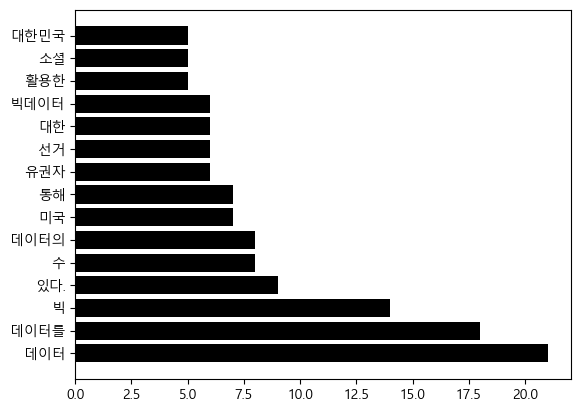

In [37]:
import matplotlib.pyplot as plt

plt.barh(range(len(v)), v, color = 'black')  # x <- from (v)alues
plt.yticks(range(len(v)), k)                 # y <- from (k)eys
plt.show()

'Nanum' 또는 'Myeongjo' 한글 폰트가 설치되었는지 확인하고, 그 중의 적당한 폰트를 사용하자.

In [38]:
from matplotlib import font_manager
for font in font_manager.fontManager.ttflist:
    if 'Myeongjo' in font.name:
        print(font.name, font.fname)

#### combineByKey

combineByKey()는 데이터를 특정 키를 기준으로 집단화하고, 집단별로 집계 작업을 수행하는 데 사용된다.

키별로 집단화하고, 집단별 합계 및 갯수 ```(key, (sum, count))```를 계산한다.

구분 | combiner | merge values | merge combiner
-----|-----|-----|-----
설명 | 새로운 키가 발견될 때마다 한 번 호출된다. 각 키에 대해 **```(value,1)```** 튜플 만든다 | 동일한 키의 값들을 병합하고, 값을 더해나감 (sum,count)<br>즉, **```sum+value```**,**```count+1```** | 다른 파티션에서 생성된 결합자를 병합하는 함수로, partition별로 combiner를 더함

- (1) combiner (lambda value: (value, 1)):

키에 대한 첫 번째 값이 주어졌을 때 호출된다. 키와 빈도 1을 튜플로 결합하여 (value, 1)로 반환한다.

- (2) mergeValue (lambda x, value: (x[0] + value, x[1] + 1)):

이미 존재하는 키에 새로운 값이 추가될 때 호출된다. x는 이미 결합된 결과 (즉, (sum, count) 형태의 튜플)이고, value는 새로 들어온 값이다. 이 함수는 기존의 합계에 새로운 값을 더하고, 카운트를 하나 증가시킨다. 결과는 (x[0] + value, x[1] + 1)로, 새로운 총합과 새로운 카운트를 반환한다.

- (3) mergeCombiners (lambda x, y: (x[0] + y[0], x[1] + y[1])): 서로 다른 파티션에서 결합된 결과를 합치는 데 사용된다.

여기서 x와 y는 두 개의 결합 결과 (sum, count)이고, 두 개의 합계를 더하고 두 개의 카운트를 더하여 최종 결과를 반환한다. 결과는 (x[0] + y[0], x[1] + y[1])로, 최종 합계와 전체 카운트이다.


* **데이터 생성**

앞서 ```_testRdd```를 사용해서 combineByKey()를 해보자.

In [2]:
_list1=[("key1",1),("key1",3),("key2",2),("key1",2),("key2",4),
           ("key1",5),("key2",6),
           ("key1",7),("key1",8),("key2",9),("key2",3)]

* **partition이 1개이면 combiner, mergeValues만 작동**

partition이 1개인 경우를 먼저 해보자. Rdd를 생성하자.

In [3]:
_testRdd1=spark.sparkContext.parallelize(_list1)

현재 partition은 1개이다.

In [22]:
_testRdd1.getNumPartitions()

1

partition이 1개이면 키별로 값을 더해간다. 키가 존재하지 않으면 combiner()를, 존재하면 mergeValues()가 실행된다.
* (key1, 1) key1은 처음 등장하는 키이므로 accumulator[key1] = createCombiner(1)
* (key1, 3) key1은 존재하는 키이므로 accumulator[key1] = mergeValue(accumulator[key1], 3)
* (key2, 2) key2는 처음 등장하는 키이므로 accumulator[key2] = createCombiner(2)
* (key1, 2) key1은 존재하는 키이므로 accumulator[key1] = mergeValue(accumulator[key1], 2)
* ...

아래 출력결과를 해석해보자.
key1의 값은 1,3,2,4,7,8이고 key2의 값은 2,4,6,9,3이다.
앞서 설명대로:
* key1의 첫째 값은 1이다. 이경우 combiner (```*```표기), 다음은 merge values (```#``` 표기)로 계산이 된다. 따라서 ```1*#3#2#5#7#8```가 출력된다.
* key2는 ```2*#4#6#9#3```가 출력된다.

In [69]:
_testRdd1.combineByKey(lambda v : str(v)+"*", lambda c, v : c+"#"+str(v), lambda c1, c2 : c1+'&'+c2).collect()

[('key1', '1*#3#2#5#7#8'), ('key2', '2*#4#6#9#3')]

앞서 서울,부산,분당에 대한 데이터에 대해 적용해보자.

In [70]:
_testRdd.combineByKey(lambda v : str(v)+"*", lambda c, v : c+"#"+str(v), lambda c1, c2 : c1+'&'+c2).collect()

[('Seoul', '1*#1#1#1#1#1#1'), ('Busan', '1*#1#1#1#1#1'), ('Bundang', '1*#1#1')]

* **partition이 복수이면 mergeCombiner가 작동**

partition이 복수인 경우에는 mergeCombiner가 작동한다. 먼저 partition을 2개로 해서 Rdd를 생성하자.

In [24]:
_testRdd2=spark.sparkContext.parallelize(_list1, 2)

In [25]:
partitions = _testRdd2.glom().collect()
for num, partition in enumerate(partitions):
    print(f'Partitions {num} -> {partition}')

Partitions 0 -> [('key1', 1), ('key1', 3), ('key2', 2), ('key1', 2), ('key2', 4)]
Partitions 1 -> [('key1', 5), ('key2', 6), ('key1', 7), ('key1', 8), ('key2', 9), ('key2', 3)]


partition이 분할 되었으므로, partition별로 합산된다.
* key1은 partition 0에서 1,3,2 그리고 partition 1에서 5,7,8이 연산된다. 그 결과 ```1*#3#2&5*#7#8```
* key2는 2,4,6과 6,9,3이 각 각 다른 partition에서 연산되어 ```2*#4&6*#9#3```이 출력된다.

In [26]:
_testRdd2.combineByKey(lambda v : str(v)+"*", lambda c, v : c+"#"+str(v), lambda c1, c2 : c1+'&'+c2).collect()

[('key1', '1*#3#2&5*#7#8'), ('key2', '2*#4&6*#9#3')]

* **실제 해보기**

앞서 사용했던 기호를 연산자로 변경해서, 실제 해보자.
그 결과는 합계, 개수를 구할 수 있게 된다.

In [28]:
_testRdd1.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),
                     lambda x,y: (x[0]+y[0], x[1]+y[1])) \
        .collect()

[('key1', (26, 6)), ('key2', (24, 5))]

* **평균 계산**

combineByKey()함수로 **sum**, **count**를 구하게 된다. 그리고 map()함수로 **sum/count**를 계산하게 된다.

In [4]:
_testCbkRdd=_testRdd1.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),                      
                     lambda x,y: (x[0]+y[0], x[1]+y[1]))

과거에는 아래와 같이 lambda 함수의 인자를 별도로 3개 받았으나, 지금은 하나를 받도록 프로그램하자.

```python
averageByKey = _testCbkRdd.map(lambda (key,(sum,count)):(key,float(sum)/count))
averageByKey.collectAsMap()
```

In [5]:
averageByKey = _testCbkRdd.map(lambda x:(x[0],x[1][0]/x[1][1]))
averageByKey.collectAsMap()

{'key1': 4.333333333333333, 'key2': 4.8}

#### combineByKey 예제

* combineByKey(x, y, z) - groupByKey()는 값 합계를 미리 계산하지 때문에 비효율적이다.
* partition별로 무작위 배분되어 실행되나, 아래는 하나의 partition을 가정하고 예제를 설명한다.
    * partition A: ('kim',86),('lim',87),('kim',91),('lim',79)
    * partition B: ('kim',75),('lim',78),('lim',92),('lee',99)

구분 | 함수명 | 설명
-----|-----|-----
x | Combiner 함수 | 값을 combine (V) -> C 예: (value,1)
y | Merge value 함수 | 값을 merge (C, V) -> C 예: (sum,count)
z | Merge combiners 함수 | combiner를 merge (C, C) -> C) 예: (K, C)

데이터 | 적용 함수 | 결과
-----|-----|-----
('kim',86) | combiner | accum[kim],(86,1)
('lim',87) | combiner | accum[lim],(87,1)
('kim',75) | merge value | (accum[kim],75) -> accum[kim],(86+75,1+1) = (161,2)
('kim',91) | merge value | (accum[kim],91) -> (161+91,2+1) = (252,3)
('lim',78) | merge value | (accum[lim],78) -> (87+78,1+1) = (165,2)
('lim',92) | merge value | (accum[lim],92) -> (165+92,2+1) = (257,3)
('lim',79) | merge value | (accum[lim],79) -> (257+79,3+1) = (336,4)
('lee',99) | combiner | accum[lee],(99,1)
partition별 합산 | merge combiners | [('lim', (336, 4)), ('lee', (99, 1)), ('kim', (252, 3))


In [15]:
marks = spark.sparkContext.parallelize([('kim',86),('lim',87),('kim',75),
                                      ('kim',91),('lim',78),('lim',92),
                                      ('lim',79),('lee',99)])

In [16]:
marksByKey = marks.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))

In [17]:
marksByKey.collect()

[('kim', (252, 3)), ('lim', (336, 4)), ('lee', (99, 1))]

In [22]:
heights = spark.sparkContext.parallelize([
        ('M',182.),('F',164.),('M',180.),('M',185.),('M',171.),('F',162.)
    ])

In [23]:
heightsByKey = heights.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))

In [24]:
heightsByKey.collect()

[('M', (718.0, 4)), ('F', (326.0, 2))]

In [25]:
avgByKey = heightsByKey.map(lambda x: (x[0],x[1][0]/x[1][1]))

print (avgByKey.collectAsMap())

{'M': 179.5, 'F': 163.0}


## 문제 S-3: 성적 합계 및 평균.

아래 데이터를 RDD로 만들고, 성적의 합계 및 평균을 계산하세요.
하위 문제별로 RDD를 생성하지 말고, 원본데이터에서 하나의 RDD만을 생성하고, 이를 변형해서 문제를 푸세요.

이름 | 과목 | 점수
-----|-----|-----
김하나 | English | 100
김하나 | Math | 80
임하나 | English | 70
임하나 | Math | 100
김갑돌 | English | 82.3
김갑돌 | Math | 98.5

* 문제 3-1: 이름으로 합계를 구해보자. 올바른 출력은 다음과 같다.
**이름과 점수로 데이터를 추출**하고, **이름별로 (이름을 키로)** 합계를 계산한다.

```python
'임하나' 170.0
'김하나' 180.0
'김갑돌' 180.8
```
* 문제 3-2: 과목으로 합계를 계산해 보자. 출력은 다음과 같이 나와야 한다.
**과목과 점수로 데이터를 추출**하여, **과목별로 (과목을 키로)** 합계를 계산한다.

```python
'English' 252.3
'Math' 278.5
```

* 문제 3-3: 이름으로 합계과 개수를 구해보자. 출력은 다음과 같이 계산된다.
**이름과 점수로 데이터를 추출**하여, **이름별로 (이름을 키로)** 합계와 개수를 계산한다.

```python
'임하나' (170.0, 2)
'김하나' (180.0, 2)
'김갑돌' (180.8, 2)
```

* 문제 3-4: 이름으로 평균을 계산해 보자. 앞서 3-3에서 사용했던 결과를 활용하고, 올바른 출력은 다음과 같다.

```python
'임하나' 85.0
'김하나' 90.0
'김갑돌' 90.4
```


### RDD 생성

우선 데이터를 만들어 보자. 이름, 과목, 성적을 개인별로 넣어 2차원 리스트로 만들어졌다.

In [87]:
marks=[
    "'김하나','English', 100",
    "'김하나','Math', 80",
    "'임하나','English', 70",
    "'임하나','Math', 100",
    "'김갑돌','English', 82.3",
    "'김갑돌','Math', 98.5"
]

In [88]:
_marksRdd=spark.sparkContext.parallelize(marks)

### 문제 3-1

개인별 데이터를 컴마로 분리하고, 이름 x[0]과 성적 x[2]만 꺼내어 reduceBykey()를 구하면 합계를 구할 수 있다.
여기서 중요한 것은 기존 데이터에서 필요한 이름, 성적만을 꺼내어 처리한다는 점이다.

In [89]:
# marks by name
_marksbyname=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[0],float(x[2])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()

In [7]:
for i in _marksbyname:
  print (i[0],i[1])

'김하나' 180.0
'임하나' 170.0
'김갑돌' 180.8


### 문제 3-2

개인별 데이터를 컴마로 분리하고, 과목 x[1]과 성적 x[2]만 꺼내어 reduceBykey()를 구하면 합계를 구할 수 있다.

In [90]:
# marks by subject
_marksbysubject=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],float(x[2])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()
for i in _marksbysubject:
  print (i[0],i[1])

'English' 252.3
'Math' 278.5


* 단계별로 풀어보기

방금 실행했던 것처럼, 한 번에 스르르 문제가 풀리지는 않는다.
단계별로 데이터를 먼저 변환하고, 그리고 문제에서 요구하는 합산을 하도록 한다.
우선 데이터를 변환하자.

In [91]:
_marksRdd\
    .map(lambda x:x.split(','))\
    .collect()

[["'김하나'", "'English'", ' 100'],
 ["'김하나'", "'Math'", ' 80'],
 ["'임하나'", "'English'", ' 70'],
 ["'임하나'", "'Math'", ' 100'],
 ["'김갑돌'", "'English'", ' 82.3'],
 ["'김갑돌'", "'Math'", ' 98.5']]

과목별 합계가 목적이므로 과목별 성적으로 변환해 놓아야 한다.

In [92]:
# marks by subject
_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],float(x[2])))\
    .collect()

[("'English'", 100.0),
 ("'Math'", 80.0),
 ("'English'", 70.0),
 ("'Math'", 100.0),
 ("'English'", 82.3),
 ("'Math'", 98.5)]

* combineByKey를 적용하면?

다음으로 어떤 함수를 적용하면 될까? 과목별 합계는 ```reduce```를 하면된다.
합계, 개수를 구한다고 combineByKey를 적용하면 어떻게 될까?
float 타입으로 combineByKey를 하면 ```'float' object is not subscriptable``` 오류가 발생한다.
그렇다고 str으로 한다고 해서 문제가 풀리는 것은 아니다.
combineByKey 함수는 합계를 계산할 수 없기 때문에 최종 값만 남기게 된다.

# ERROR! marks by subject
_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],str(x[2])))\
    .combineByKey(lambda value: (value,1),
                  lambda x, value: (x[0]+value + x[1]+1),
                  lambda x, y: x+y)\
    .collect()

* reduceByKey를 적용하면?

reduceByKey는 문자열에 대해 이어 붙이기를 하게 된다.

In [94]:
# marks by subject
_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],str(x[2])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()

[("'English'", ' 100 70 82.3'), ("'Math'", ' 80 100 98.5')]

* reduce를 적용하면?

reduce를 적용하면 어떻게 될까? 하나의 값으로 줄이려고 하기 때문에 합산이 되지 않는다.
이런 시행착오를 거치는 것은 어떻게 보면 필요하다.
문제는 단 번에 풀리지 않을 수 있다는 점에 유의하자.

In [95]:
# marks by subject
_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],float(x[2])))\
    .reduce(lambda x,y:x+y)

("'English'",
 100.0,
 "'Math'",
 80.0,
 "'English'",
 70.0,
 "'Math'",
 100.0,
 "'English'",
 82.3,
 "'Math'",
 98.5)

### 문제 3-3

합계, 개수를 계산해 보자. combineByKey()를 이용해서 계산해야 한다.
먼저 데이터를 **이름, 과목, 데이터** -> **이름, 점수**로 변경한다.

In [96]:
# marks by name
_marksbyname2=_marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[0],float(x[2])))

In [97]:
# sum, counts by name
sum_counts = _marksbyname2.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

In [98]:
for i in sum_counts.collect():
    for each in i:
        print (each, end=' ')
    print()

'김하나' (180.0, 2) 
'임하나' (170.0, 2) 
'김갑돌' (180.8, 2) 


### 문제 3-4

개인별 평균은 3-3에서 구했던 합계, 개수를 사용하여 계산한다.
평균을 계산하기 위해 float() 형변환을 해주었다.

In [99]:
# average
averageByKey = sum_counts\
    .map(lambda x: (x[0],x[1][0]/x[1][1]))\
    .collect()
for i in averageByKey:
    for j in i:
        print (j, end=' ')
    print()

'김하나' 90.0 
'임하나' 85.0 
'김갑돌' 90.4 


## 문제 S-4: 서울시 지하철호선별 승차인원 평균 구하기.

### 문제

정량데이터는 보통 집단화하고 빈도, 평균, 합계 등 서술통계를 계산한다.

'별'이란 집단화하는 기준이고, 여기서는 '호선'으로 집단화하여 승차인원의 평균을 계산한다.

데이터는 서울시 지하철호선별 역별 승하차 인원 정보 파일을 읽어서 가져오고, 그로부터 평균을 구해보자.

* 파일 명 CARD_SUBWAY_MONTH_201501.csv를 다운로드 받아서 일부만 테스트용 데이터로 사용한다.
* 참고로 오픈API 샘플URL http://openapi.seoul.go.kr:8088/(인증키)/xml/CardSubwayStatsNew/1/5/20151101

### 해결

집단화하기 위해서는 PairRDD로 만들면 해결할 수 있다. 그리고 나서 집단별로 평균을 계산할 수 있다.
평균을 계산하려면, 전체 합계와 개수가 있어야 가능하다.

평균을 계산하면 아래와 같이 작성된다.

```
[('2호선', 10529.0),
 ('3호선', 9236.0),
 ('4호선', 5704.0),
 ('경부선', 19989.6),
 ('경원선', 1194.75)]
```

### RDD 생성

* 2015년 1월 csv파일의 일부를 가져와서 리스트를 생성한다.
* 데이터 헤더: "사용일자","노선명","역ID","역명",승차총승객수,하차총승객수

In [12]:
_sub=["20150101,2호선,0236,영등포구청,6199,6219",
"20150101,2호선,0237,당산,7982,8946",
"20150101,2호선,0238,합정,17406,15241",
"20150101,3호선,0309,지축,515,538",
"20150101,3호선,0310,구파발,6879,6260",
"20150101,3호선,0311,연신내,20031,19470",
"20150101,3호선,0312,불광,9519,11029",
"20150101,4호선,0425,회현,7465,7574",
"20150101,4호선,0426,서울역,3943,10823",
"20150101,경부선,1002,남영,4340,4535",
"20150101,경부선,1003,용산,28980,27684",
"20150101,경부선,1004,노량진,23021,23862",
"20150101,경부선,1005,대방,6360,6476",
"20150101,경부선,1006,영등포,37247,36102",
"20150101,경원선,1008,이촌,1940,1507",
"20150101,경원선,1009,서빙고,911,1000",
"20150101,경원선,1010,한남,1885,1863",
"20150101,경원선,1011,옥수,43,37"]


In [15]:
_subRdd = spark.sparkContext.parallelize(_sub)

데이터가 읽혀졌는지 한 줄만 출력해보자.

In [16]:
for i in _subRdd.take(1):
    print (i)

20150101,2호선,0236,영등포구청,6199,6219


### 데이터 정리

* map()을 사용해서 컴마를 제외할 수 있다.

In [17]:
for i in _subRdd.map(lambda x:x.split(',')).collect():
    for j in i:
        print (j, end=" ")
    print()

20150101 2호선 0236 영등포구청 6199 6219 
20150101 2호선 0237 당산 7982 8946 
20150101 2호선 0238 합정 17406 15241 
20150101 3호선 0309 지축 515 538 
20150101 3호선 0310 구파발 6879 6260 
20150101 3호선 0311 연신내 20031 19470 
20150101 3호선 0312 불광 9519 11029 
20150101 4호선 0425 회현 7465 7574 
20150101 4호선 0426 서울역 3943 10823 
20150101 경부선 1002 남영 4340 4535 
20150101 경부선 1003 용산 28980 27684 
20150101 경부선 1004 노량진 23021 23862 
20150101 경부선 1005 대방 6360 6476 
20150101 경부선 1006 영등포 37247 36102 
20150101 경원선 1008 이촌 1940 1507 
20150101 경원선 1009 서빙고 911 1000 
20150101 경원선 1010 한남 1885 1863 
20150101 경원선 1011 옥수 43 37 


* 호선별 데이터 개수를 출력해 본다.
* map()의 **3번째 인덱스는 앞에서부터 4번째 철자**를 출력한다.
* 컴마로 분리해서 인덱스를 사용해야 제대로 데이터를 출력한다.

In [18]:
_subRdd.map(lambda x:int(x[3])).collect()

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [19]:
_subRdd.map(lambda x:x.split(',')).map(lambda x:int(x[4])).collect()

[6199,
 7982,
 17406,
 515,
 6879,
 20031,
 9519,
 7465,
 3943,
 4340,
 28980,
 23021,
 6360,
 37247,
 1940,
 911,
 1885,
 43]

### 총 승차인원의 합계를 reduce()로 합산한다.

* reduce()함수는 인자를 2개 받아서 합계를 구한다.

In [20]:
_subRdd.map(lambda x:x.split(',')).map(lambda x:(int(x[4]))).reduce(lambda x,y:x+y)

184666

### 호선별 승차인원 평균을 계산한다.

* Pair RDD를 사용하므로, 사전에 데이터를 (호선, 승차인원) 형식으로 구성한다.

In [21]:
_subLineByPassengers=_subRdd.map(lambda x:x.split(',')).map(lambda x: (x[1],int(x[4])))
sum_counts = _subLineByPassengers.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

In [22]:
for i in sum_counts.collect():
    for each in i:
        print (each, end=" ")
    print()

2호선 (31587, 3) 
3호선 (36944, 4) 
4호선 (11408, 2) 
경부선 (99948, 5) 
경원선 (4779, 4) 


In [23]:
for i in sum_counts.collect():
    print (i[0],i[1][0],i[1][1])

2호선 31587 3
3호선 36944 4
4호선 11408 2
경부선 99948 5
경원선 4779 4


* 위와 달리 map()을 사용하여 평균을 계산한다.

In [24]:
averageByKey = sum_counts.map(lambda x: (x[0],x[1][0]/x[1][1]))

In [25]:
averageByKey.collect()

[('2호선', 10529.0),
 ('3호선', 9236.0),
 ('4호선', 5704.0),
 ('경부선', 19989.6),
 ('경원선', 1194.75)]

## S.7 spark-submit

Spark를 설치하면, 일괄실행할 수 있는 ```spark-submit``` 명령어가 따라온다.
따라서 별도의 sys.path 설정은 하지 않아도 된다.

### log 설정

spark-submit을 실행하면 로그가 출력되는데, 그 양이 상당하다.
spark-submit을 실행하기 전, 'conf/log4j.properties'를 수정 log level을 ERROR로 설정하자.

spark가 설치된 디렉토리에서 ```conf/```로 이동하자.
그 디렉토리에서 log4j.properties.templates를 찾아서, 아래 줄을 찾아 수정하자.

```python
log4j.rootCategory=ERROR, console
```

In [2]:
%%writefile src/ds_spark_rdd_hello.py
#!/usr/bin/env python3
# -*- coding: UTF-8 -*-
import pyspark
import os

os.environ['HADOOP_HOME']=os.getcwd()
os.environ["PATH"] += os.path.join(os.environ['HADOOP_HOME'], 'bin')

def doIt():
    print ("---------RESULT-----------")
    print (spark.version)
    spark.conf.set("spark.logConf","false")
    rdd=spark.sparkContext.parallelize(range(1000), 10)
    print ("mean=",rdd.mean())
    nums = spark.sparkContext.parallelize([1, 2, 3, 4])
    squared = nums.map(lambda x: x * x).collect()
    for num in squared:
        print ("{} ".format(num))

if __name__ == "__main__":

    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_rdd_hello.py


In [ ]:
일괄실행을 해보자. 실행주체는 (1) Python 인터프리터이거나 (2) 스파크 클러스터가 모두 가능하고, 우선 (1) Python으로 해보자.

In [3]:
!python3 src/ds_spark_rdd_hello.py

---------RESULT-----------
3.4.1
mean= 499.5
1 
4 
9 
16 
SUCCESS: The process with PID 32848 (child process of PID 38264) has been terminated.
SUCCESS: The process with PID 38264 (child process of PID 26648) has been terminated.
SUCCESS: The process with PID 26648 (child process of PID 30020) has been terminated.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).

[Stage 0:>                                                         (0 + 1) / 10]

[Stage 0:=====>                                                    (1 + 1) / 10]

[Stage 0:===========>                                              (2 + 1) / 10]

[Stage 0:=================>                                        (3 + 1) / 10]

[Stage 0:=======================>                                  (4 + 1) / 10]

[Stage 0:=============================>                            (5 + 1) / 10]

[Stage 0:==================================>                       (6 + 1) / 10]

[Stage 0:========================================>                 (7 + 1) / 10]

[Stage 0:==============================================>           (8 + 1) / 10]

[Stage 0:====================================================>     (9 + 1) / 10]
23/10/09 09:42:02 WARN GarbageCollectionMetrics: T

이번에는 스파크 클러스터에 위 파일을 넘겨 일괄 실행하도록 한다. 잠깐, 실행명령 spark-submit은 어디에서 온 것일까?

윈도우에서는 where 명령으로 간단히 알 수 있다 (리눅스는 which)

In [96]:
!where spark-submit

C:\Users\jsl\AppData\Roaming\Python\Python39\Scripts\spark-submit
C:\Users\jsl\AppData\Roaming\Python\Python39\Scripts\spark-submit.cmd


!spark-submit src/ds_spark_rdd_hello.py

```
---------RESULT-----------
3.4.1
mean= 499.5
1 
4 
9 
16 

환경변수를 읽지 못하고 있다. os.environ의 설정은 주피터노트북에서는 효과적, 여기서는 그렇지 않으니 외부에서 설정해야겠다.
23/10/09 09:40:43 WARN Shell: Did not find winutils.exe: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
23/10/09 09:40:44 INFO SparkContext: Running Spark version 3.4.1
23/10/09 09:40:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/09 09:40:45 INFO ResourceUtils: ==============================================================
23/10/09 09:40:45 INFO ResourceUtils: No custom resources configured for spark.driver.
23/10/09 09:40:45 INFO ResourceUtils: ==============================================================
23/10/09 09:40:45 INFO SparkContext: Submitted application: myApp
컴퓨팅 자원을 할당하고 있다.
23/10/09 09:40:45 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
23/10/09 09:40:45 INFO ResourceProfile: Limiting resource is cpu
23/10/09 09:40:45 INFO ResourceProfileManager: Added ResourceProfile id: 0
보안 설정을 하고 있다. 윈도우와 달리 유닉스/리눅스에서 기본으로 필요한 설정이다.
23/10/09 09:40:45 INFO SecurityManager: Changing view acls to: jsl
23/10/09 09:40:45 INFO SecurityManager: Changing modify acls to: jsl
23/10/09 09:40:45 INFO SecurityManager: Changing view acls groups to: 
23/10/09 09:40:45 INFO SecurityManager: Changing modify acls groups to: 
23/10/09 09:40:45 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users with view permissions: jsl; groups with view permissions: EMPTY; users with modify permissions: jsl; groups with modify permissions: EMPTY
23/10/09 09:40:45 INFO Utils: Successfully started service 'sparkDriver' on port 53654.
23/10/09 09:40:45 INFO SparkEnv: Registering MapOutputTracker
23/10/09 09:40:45 INFO SparkEnv: Registering BlockManagerMaster
23/10/09 09:40:45 INFO BlockManagerMasterEndpoint: Using org.apache.spark.storage.DefaultTopologyMapper for getting topology information
23/10/09 09:40:45 INFO BlockManagerMasterEndpoint: BlockManagerMasterEndpoint up
23/10/09 09:40:46 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
임시 출력에 필요한 디렉토리 설정이다.
23/10/09 09:40:46 INFO DiskBlockManager: Created local directory at C:\Users\jsl\AppData\Local\Temp\blockmgr-93eb2a31-9827-4400-97a3-4ea9e3cf67c4
23/10/09 09:40:46 INFO MemoryStore: MemoryStore started with capacity 434.4 MiB
23/10/09 09:40:46 INFO SparkEnv: Registering OutputCommitCoordinator
23/10/09 09:40:46 INFO JettyUtils: Start Jetty 0.0.0.0:4040 for SparkUI
23/10/09 09:40:46 INFO Utils: Successfully started service 'SparkUI' on port 4040.
워커의 executor 설정이다.
23/10/09 09:40:46 INFO Executor: Starting executor ID driver on host 192.168.219.151
23/10/09 09:40:46 INFO Executor: Starting executor with user classpath (userClassPathFirst = false): ''
23/10/09 09:40:46 INFO Utils: Successfully started service 'org.apache.spark.network.netty.NettyBlockTransferService' on port 53658.
23/10/09 09:40:46 INFO NettyBlockTransferService: Server created on 192.168.219.151:53658
23/10/09 09:40:46 INFO BlockManager: Using org.apache.spark.storage.RandomBlockReplicationPolicy for block replication policy
23/10/09 09:40:46 INFO BlockManagerMaster: Registering BlockManager BlockManagerId(driver, 192.168.219.151, 53658, None)
23/10/09 09:40:46 INFO BlockManagerMasterEndpoint: Registering block manager 192.168.219.151:53658 with 434.4 MiB RAM, BlockManagerId(driver, 192.168.219.151, 53658, None)
23/10/09 09:40:46 INFO BlockManagerMaster: Registered BlockManager BlockManagerId(driver, 192.168.219.151, 53658, None)
23/10/09 09:40:46 INFO BlockManager: Initialized BlockManager: BlockManagerId(driver, 192.168.219.151, 53658, None)
23/10/09 09:40:47 INFO SharedState: Setting hive.metastore.warehouse.dir ('null') to the value of spark.sql.warehouse.dir.
현재 디렉토리에 필요한 웨어하우스 설정이다.
23/10/09 09:40:47 INFO SharedState: Warehouse path is 'file:/C:/Users/jsl/Code/201711111/spark-warehouse'.
작업의 시작을 알리고 있다.
23/10/09 09:40:48 INFO SparkContext: Starting job: mean at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:14
작업계획이 시작된다.
23/10/09 09:40:48 INFO DAGScheduler: Got job 0 (mean at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:14) with 10 output partitions
23/10/09 09:40:48 INFO DAGScheduler: Final stage: ResultStage 0 (mean at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:14)
23/10/09 09:40:48 INFO DAGScheduler: Parents of final stage: List()
23/10/09 09:40:48 INFO DAGScheduler: Missing parents: List()
23/10/09 09:40:48 INFO DAGScheduler: Submitting ResultStage 0 (PythonRDD[1] at mean at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:14), which has no missing parents
23/10/09 09:40:48 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 7.8 KiB, free 434.4 MiB)
23/10/09 09:40:48 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 4.8 KiB, free 434.4 MiB)
23/10/09 09:40:48 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on 192.168.219.151:53658 (size: 4.8 KiB, free: 434.4 MiB)
23/10/09 09:40:48 INFO SparkContext: Created broadcast 0 from broadcast at DAGScheduler.scala:1535
작업 tasks이 시작된다.
23/10/09 09:40:48 INFO DAGScheduler: Submitting 10 missing tasks from ResultStage 0 (PythonRDD[1] at mean at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:14) (first 15 tasks are for partitions Vector(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
23/10/09 09:40:48 INFO TaskSchedulerImpl: Adding task set 0.0 with 10 tasks resource profile 0
23/10/09 09:40:48 INFO TaskSetManager: Starting task 0.0 in stage 0.0 (TID 0) (192.168.219.151, executor driver, partition 0, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:48 INFO Executor: Running task 0.0 in stage 0.0 (TID 0)
23/10/09 09:40:50 INFO PythonRunner: Times: total = 1135, boot = 1121, init = 13, finish = 1
23/10/09 09:40:50 INFO Executor: Finished task 0.0 in stage 0.0 (TID 0). 1592 bytes result sent to driver
23/10/09 09:40:50 INFO TaskSetManager: Starting task 1.0 in stage 0.0 (TID 1) (192.168.219.151, executor driver, partition 1, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:50 INFO Executor: Running task 1.0 in stage 0.0 (TID 1)
23/10/09 09:40:50 INFO TaskSetManager: Finished task 0.0 in stage 0.0 (TID 0) in 1351 ms on 192.168.219.151 (executor driver) (1/10)
23/10/09 09:40:50 INFO PythonAccumulatorV2: Connected to AccumulatorServer at host: 127.0.0.1 port: 53659
23/10/09 09:40:51 INFO PythonRunner: Times: total = 1159, boot = 1156, init = 2, finish = 1
23/10/09 09:40:51 INFO Executor: Finished task 1.0 in stage 0.0 (TID 1). 1549 bytes result sent to driver
23/10/09 09:40:51 INFO TaskSetManager: Starting task 2.0 in stage 0.0 (TID 2) (192.168.219.151, executor driver, partition 2, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:51 INFO Executor: Running task 2.0 in stage 0.0 (TID 2)
23/10/09 09:40:51 INFO TaskSetManager: Finished task 1.0 in stage 0.0 (TID 1) in 1205 ms on 192.168.219.151 (executor driver) (2/10)
23/10/09 09:40:52 INFO PythonRunner: Times: total = 1041, boot = 1038, init = 2, finish = 1
23/10/09 09:40:52 INFO Executor: Finished task 2.0 in stage 0.0 (TID 2). 1549 bytes result sent to driver
23/10/09 09:40:52 INFO TaskSetManager: Starting task 3.0 in stage 0.0 (TID 3) (192.168.219.151, executor driver, partition 3, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:52 INFO Executor: Running task 3.0 in stage 0.0 (TID 3)
23/10/09 09:40:52 INFO TaskSetManager: Finished task 2.0 in stage 0.0 (TID 2) in 1073 ms on 192.168.219.151 (executor driver) (3/10)
23/10/09 09:40:53 INFO PythonRunner: Times: total = 1176, boot = 1173, init = 2, finish = 1
23/10/09 09:40:53 INFO Executor: Finished task 3.0 in stage 0.0 (TID 3). 1506 bytes result sent to driver
23/10/09 09:40:53 INFO TaskSetManager: Starting task 4.0 in stage 0.0 (TID 4) (192.168.219.151, executor driver, partition 4, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:53 INFO Executor: Running task 4.0 in stage 0.0 (TID 4)
23/10/09 09:40:53 INFO TaskSetManager: Finished task 3.0 in stage 0.0 (TID 3) in 1211 ms on 192.168.219.151 (executor driver) (4/10)
23/10/09 09:40:55 INFO PythonRunner: Times: total = 1457, boot = 1455, init = 2, finish = 0
23/10/09 09:40:55 INFO Executor: Finished task 4.0 in stage 0.0 (TID 4). 1549 bytes result sent to driver
23/10/09 09:40:55 INFO TaskSetManager: Starting task 5.0 in stage 0.0 (TID 5) (192.168.219.151, executor driver, partition 5, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:55 INFO TaskSetManager: Finished task 4.0 in stage 0.0 (TID 4) in 1494 ms on 192.168.219.151 (executor driver) (5/10)
23/10/09 09:40:55 INFO Executor: Running task 5.0 in stage 0.0 (TID 5)
23/10/09 09:40:56 INFO PythonRunner: Times: total = 1233, boot = 1231, init = 2, finish = 0
23/10/09 09:40:56 INFO Executor: Finished task 5.0 in stage 0.0 (TID 5). 1506 bytes result sent to driver
23/10/09 09:40:56 INFO TaskSetManager: Starting task 6.0 in stage 0.0 (TID 6) (192.168.219.151, executor driver, partition 6, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:56 INFO Executor: Running task 6.0 in stage 0.0 (TID 6)
23/10/09 09:40:56 INFO TaskSetManager: Finished task 5.0 in stage 0.0 (TID 5) in 1275 ms on 192.168.219.151 (executor driver) (6/10)
23/10/09 09:40:57 INFO PythonRunner: Times: total = 1247, boot = 1245, init = 1, finish = 1
23/10/09 09:40:57 INFO Executor: Finished task 6.0 in stage 0.0 (TID 6). 1506 bytes result sent to driver
23/10/09 09:40:57 INFO TaskSetManager: Starting task 7.0 in stage 0.0 (TID 7) (192.168.219.151, executor driver, partition 7, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:57 INFO Executor: Running task 7.0 in stage 0.0 (TID 7)
23/10/09 09:40:57 INFO TaskSetManager: Finished task 6.0 in stage 0.0 (TID 6) in 1287 ms on 192.168.219.151 (executor driver) (7/10)
23/10/09 09:40:58 INFO PythonRunner: Times: total = 1081, boot = 1078, init = 2, finish = 1
23/10/09 09:40:58 INFO Executor: Finished task 7.0 in stage 0.0 (TID 7). 1549 bytes result sent to driver
23/10/09 09:40:58 INFO TaskSetManager: Starting task 8.0 in stage 0.0 (TID 8) (192.168.219.151, executor driver, partition 8, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:40:58 INFO TaskSetManager: Finished task 7.0 in stage 0.0 (TID 7) in 1124 ms on 192.168.219.151 (executor driver) (8/10)
23/10/09 09:40:58 INFO Executor: Running task 8.0 in stage 0.0 (TID 8)
23/10/09 09:40:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
23/10/09 09:41:00 INFO PythonRunner: Times: total = 1258, boot = 1256, init = 2, finish = 0
23/10/09 09:41:00 INFO Executor: Finished task 8.0 in stage 0.0 (TID 8). 1592 bytes result sent to driver
23/10/09 09:41:00 INFO TaskSetManager: Starting task 9.0 in stage 0.0 (TID 9) (192.168.219.151, executor driver, partition 9, PROCESS_LOCAL, 7343 bytes) 
23/10/09 09:41:00 INFO TaskSetManager: Finished task 8.0 in stage 0.0 (TID 8) in 1296 ms on 192.168.219.151 (executor driver) (9/10)
23/10/09 09:41:00 INFO Executor: Running task 9.0 in stage 0.0 (TID 9)
23/10/09 09:41:01 INFO PythonRunner: Times: total = 1164, boot = 1161, init = 2, finish = 1
23/10/09 09:41:01 INFO Executor: Finished task 9.0 in stage 0.0 (TID 9). 1549 bytes result sent to driver
23/10/09 09:41:01 INFO TaskSetManager: Finished task 9.0 in stage 0.0 (TID 9) in 1192 ms on 192.168.219.151 (executor driver) (10/10)
23/10/09 09:41:01 INFO TaskSchedulerImpl: Removed TaskSet 0.0, whose tasks have all completed, from pool 
23/10/09 09:41:01 INFO DAGScheduler: ResultStage 0 (mean at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:14) finished in 12.764 s
23/10/09 09:41:01 INFO DAGScheduler: Job 0 is finished. Cancelling potential speculative or zombie tasks for this job
23/10/09 09:41:01 INFO TaskSchedulerImpl: Killing all running tasks in stage 0: Stage finished
23/10/09 09:41:01 INFO DAGScheduler: Job 0 finished: mean at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:14, took 12.834734 s
23/10/09 09:41:01 INFO SparkContext: Starting job: collect at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:16
23/10/09 09:41:01 INFO DAGScheduler: Got job 1 (collect at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:16) with 1 output partitions
23/10/09 09:41:01 INFO DAGScheduler: Final stage: ResultStage 1 (collect at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:16)
23/10/09 09:41:01 INFO DAGScheduler: Parents of final stage: List()
23/10/09 09:41:01 INFO DAGScheduler: Missing parents: List()
23/10/09 09:41:01 INFO DAGScheduler: Submitting ResultStage 1 (PythonRDD[3] at collect at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:16), which has no missing parents
23/10/09 09:41:01 INFO MemoryStore: Block broadcast_1 stored as values in memory (estimated size 5.7 KiB, free 434.4 MiB)
23/10/09 09:41:01 INFO MemoryStore: Block broadcast_1_piece0 stored as bytes in memory (estimated size 3.7 KiB, free 434.4 MiB)
23/10/09 09:41:01 INFO BlockManagerInfo: Added broadcast_1_piece0 in memory on 192.168.219.151:53658 (size: 3.7 KiB, free: 434.4 MiB)
23/10/09 09:41:01 INFO SparkContext: Created broadcast 1 from broadcast at DAGScheduler.scala:1535
23/10/09 09:41:01 INFO DAGScheduler: Submitting 1 missing tasks from ResultStage 1 (PythonRDD[3] at collect at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:16) (first 15 tasks are for partitions Vector(0))
23/10/09 09:41:01 INFO TaskSchedulerImpl: Adding task set 1.0 with 1 tasks resource profile 0
23/10/09 09:41:01 INFO TaskSetManager: Starting task 0.0 in stage 1.0 (TID 10) (192.168.219.151, executor driver, partition 0, PROCESS_LOCAL, 7377 bytes) 
23/10/09 09:41:01 INFO Executor: Running task 0.0 in stage 1.0 (TID 10)
23/10/09 09:41:02 INFO PythonRunner: Times: total = 1010, boot = 1009, init = 1, finish = 0
23/10/09 09:41:02 INFO Executor: Finished task 0.0 in stage 1.0 (TID 10). 1337 bytes result sent to driver
23/10/09 09:41:02 INFO TaskSetManager: Finished task 0.0 in stage 1.0 (TID 10) in 1041 ms on 192.168.219.151 (executor driver) (1/1)
23/10/09 09:41:02 INFO TaskSchedulerImpl: Removed TaskSet 1.0, whose tasks have all completed, from pool 
23/10/09 09:41:02 INFO DAGScheduler: ResultStage 1 (collect at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:16) finished in 1.054 s
23/10/09 09:41:02 INFO DAGScheduler: Job 1 is finished. Cancelling potential speculative or zombie tasks for this job
23/10/09 09:41:02 INFO TaskSchedulerImpl: Killing all running tasks in stage 1: Stage finished
23/10/09 09:41:02 INFO DAGScheduler: Job 1 finished: collect at C:\Users\jsl\Code\201711111\src\ds_spark_rdd_hello.py:16, took 1.059589 s
23/10/09 09:41:02 INFO SparkContext: SparkContext is stopping with exitCode 0.
23/10/09 09:41:02 INFO SparkUI: Stopped Spark web UI at http://192.168.219.151:4040
23/10/09 09:41:02 INFO MapOutputTrackerMasterEndpoint: MapOutputTrackerMasterEndpoint stopped!
23/10/09 09:41:02 INFO MemoryStore: MemoryStore cleared
23/10/09 09:41:02 INFO BlockManager: BlockManager stopped
23/10/09 09:41:02 INFO BlockManagerMaster: BlockManagerMaster stopped
23/10/09 09:41:02 INFO OutputCommitCoordinator$OutputCommitCoordinatorEndpoint: OutputCommitCoordinator stopped!
23/10/09 09:41:02 INFO SparkContext: Successfully stopped SparkContext
23/10/09 09:41:03 INFO ShutdownHookManager: Shutdown hook called
23/10/09 09:41:03 INFO ShutdownHookManager: Deleting directory C:\Users\jsl\AppData\Local\Temp\spark-35b5b5cc-3398-4f28-90e7-6b27cb81bc39
23/10/09 09:41:03 INFO ShutdownHookManager: Deleting directory C:\Users\jsl\AppData\Local\Temp\spark-deb95f0c-e0df-4745-b0b1-c4119fae9fb4
23/10/09 09:41:03 INFO ShutdownHookManager: Deleting directory C:\Users\jsl\AppData\Local\Temp\spark-35b5b5cc-3398-4f28-90e7-6b27cb81bc39\pyspark-70ea527c-260c-400c-904f-4dcbe98f869e
23/10/09 09:41:03 ERROR ShutdownHookManager: Exception while deleting Spark temp dir: C:\Users\jsl\AppData\Local\Temp\spark-35b5b5cc-3398-4f28-90e7-6b27cb81bc39\pyspark-70ea527c-260c-400c-904f-4dcbe98f869e
java.nio.file.NoSuchFileException: C:\Users\jsl\AppData\Local\Temp\spark-35b5b5cc-3398-4f28-90e7-6b27cb81bc39\pyspark-70ea527c-260c-400c-904f-4dcbe98f869e
	at java.base/sun.nio.fs.WindowsException.translateToIOException(WindowsException.java:85)
	at java.base/sun.nio.fs.WindowsException.rethrowAsIOException(WindowsException.java:103)
	at java.base/sun.nio.fs.WindowsException.rethrowAsIOException(WindowsException.java:108)
	at java.base/sun.nio.fs.WindowsFileAttributeViews$Basic.readAttributes(WindowsFileAttributeViews.java:53)
	at java.base/sun.nio.fs.WindowsFileAttributeViews$Basic.readAttributes(WindowsFileAttributeViews.java:38)
	at java.base/sun.nio.fs.WindowsFileSystemProvider.readAttributes(WindowsFileSystemProvider.java:197)
	at java.base/java.nio.file.Files.readAttributes(Files.java:1848)
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingJavaIO(JavaUtils.java:128)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:121)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1231)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4(ShutdownHookManager.scala:65)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4$adapted(ShutdownHookManager.scala:62)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$2(ShutdownHookManager.scala:62)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:214)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:577)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:317)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
```

In [10]:
%%writefile src/ds_spark_rdd_reduceBykey.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
import os

os.environ['HADOOP_HOME']=os.getcwd()
os.environ["PATH"] += os.path.join(os.environ['HADOOP_HOME'], 'bin')

def doIt():
    print("---------RESULT-----------")
    myRdd=spark.sparkContext\
        .textFile(os.path.join("data","ds_spark_wiki.txt"))
    res=myRdd\
        .flatMap(lambda x:x.split())\
        .map(lambda x:(x,1))\
        .reduceByKey(lambda x,y:x+y)\
        .map(lambda x:(x[1],x[0]))\
        .sortByKey(False)\
        .take(10)
    for i in res:
        print(i)

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_rdd_reduceBykey.py


In [11]:
!python3 src/ds_spark_rdd_reduceBykey.py

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).

[Stage 0:>                                                          (0 + 1) / 1]

[Stage 1:>                                                          (0 + 1) / 1]

                                                                                


---------RESULT-----------
(7, 'Spark')
(6, 'Apache')
(5, '아파치')
(4, '스파크')
(3, 'the')
(2, 'an')
(1, 'Wikipedia')
(1, 'is')
(1, 'open')
(1, 'source')
SUCCESS: The process with PID 20740 (child process of PID 20140) has been terminated.
SUCCESS: The process with PID 20140 (child process of PID 852) has been terminated.
SUCCESS: The process with PID 852 (child process of PID 37984) has been terminated.


In [23]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_rdd_reduceBykey.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

## 문제 S-4: RDD를 사용하여 word vector를 생성하기.

### 문제
사람은 연설이나 에세이 등을 읽고 나면 그 내용이 무엇이고 무엇을 말하려고 하는지 알 수 있다. 주제가 무엇이고 심지어는 숨겨진 행간도 이해할 수 있다.
그러나 컴퓨터는 문서를 읽고 의미를 파악해 내는 것이 쉽지 않다.
그 대신 문서에 어떤 단어가 쓰였고, 많이 쓰인 단어가 무엇인지 알아내어 어떤 내용인지 알아내게 된다.
이 경우 쓰인 단어의 빈도를 **word vector**라고 하며, 문서로 부터 이를 만들어 내는 작업이 필요하다.

> **Bag of words** 모델
> 
> BoW 모델은 텍스트 문서를 단어의 집합 "bag of words"으로 보고 수치 데이터로 변환하는 것을 말하여, 기계학습 또는 텍스트 분석에 사용할 수 있다.

> BoW는 간단하고 이해하기 쉬우며, 문맥을 무시하고 단어의 순서를 고려하지 않는 한계가 있다. 이러한 한계를 극복하기 위해 Word2Vec, FastText, BERT 등과 같은 고급 자연어 처리 기술이 개발되었다.

> 텍스트 -> 전처리 (특수문자, 불용어 등 제거) -> 토큰화 (단어로 분할) -> 어휘사전, 단어빈도 구축 -> Word Vector(단어와 빈도)로 표현할 수 있다.

> 문장 | 단어 | bag of words 표현
> -----|-----|-----
> I like to play football. | I, like, to, play, football | {"I":1, "like":1, "to":1, "play":1, "football":1}
> He also likes to play football. | He, also, likes, to, play, football | {"He":1, "also":1, "likes":1, "to":1, "play":1, "football":1}

### 해결

분석하려는 문서를 RDD로 만들고, map-reduce 알고리듬으로 단어의 빈도를 계산할 수 있다.

```Spark mllib``` 라이브러리에서는 자연어처리 기법을 제공하고 있다.
TF-IDF, Word2Vec 등을 사용하면 단어의 빈도 및 관련어 등을 분석해 낼 수 있다.

다음 장에서 배우겠지만 데이터프레임을 생성하고 ml 라이브러를 사용할 수도 있다.
ml은 DataFrame을 위한 라이브러리로서 Tokenizer, Stopwords, NGram 등을 분석할 수도 있다.

### RDD 생성

파일 전체를 읽어서, 단어의 수를 세어 본다.

줄 | 설명
-----|-----
1 | sparkContext.textFile()로 파일을 읽어 RDD로 만든다.
2 | flatMap()을 으로 공백으로 분리하여 RDD를 생성한다. 이러한 변환은 실제 연산까지 일어나지 않는다, 즉 lazy변환이다.

파일은 이미 만들어 놓은 wiki를 사용한다. 아래와 같이 파일이 있는지 확인해 본다.

In [12]:
import os
os.path.isfile(os.path.join("data","ds_spark_wiki.txt"))

True

RDD를 생성해보자. 문서파일은 문장으로 이루어져 있고, 이를 기준으로 word vector를 구성할 수 있다.
그러나 문서 **전체**를 word vector로 표현하려면 **flatMap()** 함수를 사용해야 한다.

In [13]:
import os
wikiRdd=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))

### 단어집합

문장을 split()으로 분리하여 단어의 집합으로 만든다. 리스트를 모두 1차원으로 만드는 flatMap() 함수를 사용한다.

In [31]:
words=wikiRdd\
    .flatMap(lambda x: x.split())

아직 중간과정이므로 PipelineRDD가 만들어졌다.

In [76]:
print (type(words))

<class 'pyspark.rdd.PipelinedRDD'>


단어의 개수는 count() 함수로 알 수 있다.

In [32]:
print ("단어 갯수: ", words.count())

단어 갯수:  72


앞서 분리된 단어를 collect()함수로 취합한다.
**collect() 결과는 list**로 만들어 진다.
모든 항목을 출력하려면 list의 인덱스 [:]를 사용한다.
유니코드를 지원하므로, 한글이 잘 출력되고 있다.

In [33]:
print ("전체 단어: ", words.collect()[0:72])

전체 단어:  ['Wikipedia', 'Apache', 'Spark', 'is', 'an', 'open', 'source', 'cluster', 'computing', 'framework.', '아파치', '스파크는', '오픈', '소스', '클러스터', '컴퓨팅', '프레임워크이다.', 'Apache', 'Spark', 'Apache', 'Spark', 'Apache', 'Spark', 'Apache', 'Spark', '아파치', '스파크', '아파치', '스파크', '아파치', '스파크', '아파치', '스파크', 'Originally', 'developed', 'at', 'the', 'University', 'of', 'California,', "Berkeley's", 'AMPLab,', 'the', 'Spark', 'codebase', 'was', 'later', 'donated', 'to', 'the', 'Apache', 'Software', 'Foundation,', 'which', 'has', 'maintained', 'it', 'since.', 'Spark', 'provides', 'an', 'interface', 'for', 'programming', 'entire', 'clusters', 'with', 'implicit', 'data', 'parallelism', 'and', 'fault-tolerance.']


### 단어빈도

이제 map-reduce를 같이 사용하여 단어를 세어 tuple로 만들어 보자. 즉 **(단어, 1) 구조**로 만들어 **같은 단어는 나중에 서로 더할 수** 있게 만들어 놓는다.

In [15]:
wc = spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))

- L2: flatMap()은 리스트나 배열같은 구조를 하나의 평면(flat)의 리스트로 만든다. 그 함수 안의 .split()은 앞서 설명한 바와 같이 파일 텍스트를 공백으로 분리한다.
- L3: map()함수는 (단어, 1) 이런 식으로 tuple로 만든다.
    - .lower()는 모든 단어를 소문자로 만들고,
    - .rstrip(), .lstrp() 함수는 **양끝에 붙어있을 수 있는 불필요한 구문 (new lines, commas, periods)을 제거**하는데, 매개변수가 없으면 whitespace를 제거한다.

함수 | 설명
-----|-----
rstrip() | 꼬리에 붙는 문자를 제거
lstrip() | 머리에 붙는 문자를 제거

아직 단어별로 갯수를 계산하지 않았기 때문에, 모두 1인 값을 가진다.
sortByKey()는 **올림차순**을 기본으로 정렬한다.

In [35]:
wc.sortByKey().take(5)

[('amplab', 1), ('an', 1), ('an', 1), ('and', 1), ('apache', 1)]

### 빈도 집계

이제 단어의 갯수를 합계내어 보자. 아래 방법 모두 **동일한 결과를 산출**한다.

구분 | 설명
-----|-----
```reduceByKey(add)``` | ```add``` operator를 사용하면, 단어튜플의 수를 키별로 더할 수 있다.
```groupByKey().mapValues(sum)``` | ```mapValues()```를 사용하여 value의 'sum'을 계산할 수 있다.
```groupByKey().map(lambda (x,iter): (x,len(iter)))``` | (key,value)의 구조를 사용하여 합계를 계산할 수 있다.

### 하나. reduceByKey()

Python의 연산자 add() 함수를 사용해서 할 수 있다.
**operator.add()**는 reduce()함수의 숫자 인자 x,y를 받아서 x+y 연산을 한다.

In [85]:
from operator import add
wcReduceByKey = wc.reduceByKey(add)

In [86]:
wcReduceByKey.sortByKey().take(10)

[('amplab', 1),
 ('an', 2),
 ('and', 1),
 ('apache', 6),
 ('at', 1),
 ("berkeley's", 1),
 ('california', 1),
 ('cluster', 1),
 ('clusters', 1),
 ('codebase', 1)]

또는 add대신에 reduceByKey()에 lambda함수를 사용해도 된다.

In [16]:
wcReduceByKey = wc.reduceByKey(lambda x,y:x+y)

In [19]:
wcReduceByKey.sortByKey().take(10)

[('amplab', 1),
 ('an', 2),
 ('and', 1),
 ('apache', 6),
 ('at', 1),
 ("berkeley's", 1),
 ('california', 1),
 ('cluster', 1),
 ('clusters', 1),
 ('codebase', 1)]

In [75]:
import os
wikiRdd=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))

wc=wikiRdd\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))\
    .reduceByKey(lambda x,y:x+y)

In [84]:
wcReduceByKey.sortByKey().take(10)

[('amplab', 1),
 ('an', 2),
 ('and', 1),
 ('apache', 6),
 ('at', 1),
 ("berkeley's", 1),
 ('california', 1),
 ('cluster', 1),
 ('clusters', 1),
 ('codebase', 1)]

### 둘. groupByKey(), mapValues()

groupByKey()는 단어키로 동일한 단어는 집단화한다.
집단화 하면 **PairRDD가 되고, 즉 key-value 쌍**으로 구성된다.
**mapValues()는 각 쌍의 value에 대해서 sum 연산**을 한다.

In [87]:
wcGroupByKey = wc.groupByKey().mapValues(sum)

In [88]:
wcGroupByKey.sortByKey().take(10)

[('amplab', 1),
 ('an', 2),
 ('and', 1),
 ('apache', 6),
 ('at', 1),
 ("berkeley's", 1),
 ('california', 1),
 ('cluster', 1),
 ('clusters', 1),
 ('codebase', 1)]

### 셋. groupByKey(), map, len

mapValues()를 사용하지 않고 map()으로 **len()**갯수를 세어도 동일한 결과를 얻을 수 있다.
**단어별로 1개씩 만들어 놓았으므로 len()으로 세면 단어갯수의 합계**가 된다.

전에는 ```wc.groupByKey().map(lambda (x,v): (x,len(v)))```

In [101]:
wcGroupByKey2 = wc.groupByKey().map(lambda x: (x[0],len(x[1])))

In [102]:
wcGroupByKey2.sortByKey().take(10)

[('amplab', 1),
 ('an', 2),
 ('and', 1),
 ('apache', 6),
 ('at', 1),
 ("berkeley's", 1),
 ('california', 1),
 ('cluster', 1),
 ('clusters', 1),
 ('codebase', 1)]

### 넷. 줄로 구분하여 단어 빈도

```flatMap()```을 사용하지 않으면 **줄로 구분하여 단어 빈도**를 셀 수 있다.
줄로 구분하여 리스트를 만들게 되므로, 결과는 2차원 리스트가 된다.

줄 | 설명
-----|-----
1 | ```sparkContext.textFile()``` 파일을 읽어 RDD 생성
2 | 불필요한 컴마, 점, 하이픈을 제거하고 소문자로
3 | 공백으로 분리
4 | 반복문으로 단어별 튜플구조화

In [122]:
wc = spark.sparkContext.textFile("data/ds_spark_wiki.txt")\
    .map(lambda x: x.replace(',',' ').replace('.',' ').replace('-',' ').lower())\
    .map(lambda x:x.split())\
    .map(lambda x:[(i,1) for i in x])

In [104]:
for e in wc.collect():
    print (e)

[('wikipedia', 1)]
[('apache', 1), ('spark', 1), ('is', 1), ('an', 1), ('open', 1), ('source', 1), ('cluster', 1), ('computing', 1), ('framework', 1)]
[('아파치', 1), ('스파크는', 1), ('오픈', 1), ('소스', 1), ('클러스터', 1), ('컴퓨팅', 1), ('프레임워크이다', 1)]
[('apache', 1), ('spark', 1), ('apache', 1), ('spark', 1), ('apache', 1), ('spark', 1), ('apache', 1), ('spark', 1)]
[('아파치', 1), ('스파크', 1), ('아파치', 1), ('스파크', 1), ('아파치', 1), ('스파크', 1), ('아파치', 1), ('스파크', 1)]
[('originally', 1), ('developed', 1), ('at', 1), ('the', 1), ('university', 1), ('of', 1), ('california', 1), ("berkeley's", 1), ('amplab', 1)]
[('the', 1), ('spark', 1), ('codebase', 1), ('was', 1), ('later', 1), ('donated', 1), ('to', 1), ('the', 1), ('apache', 1), ('software', 1), ('foundation', 1)]
[('which', 1), ('has', 1), ('maintained', 1), ('it', 1), ('since', 1)]
[('spark', 1), ('provides', 1), ('an', 1), ('interface', 1), ('for', 1), ('programming', 1), ('entire', 1), ('clusters', 1), ('with', 1)]
[('implicit', 1), ('data', 1), ('

### 묶어서

지금까지의 작업을 프로그램으로 묶어보면 다음과 같다.

In [120]:
%%writefile src/ds_rdd_wordCount.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-

import pyspark
import os

def doIt():
    wikiRdd=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))
    wc=wikiRdd\
        .flatMap(lambda x: x.split())\
        .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))\
        .reduceByKey(lambda x,y:x+y)\
        .sortByKey()\
        .collect()
    for w in wc:
        print (w)

if __name__ == "__main__":
    #os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
    #os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_rdd_wordCount.py


- L1: Unix/Linux 운영 체제에서 사용되며, 스크립트 파일의 첫 부분에 위치하여 해당 스크립트를 실행할 Python 인터프리터를 지정. 윈도우에서는 인식되지 않으며, 파일을 확장자 .py로 저장하면 실행할 Python 인터프리터를 지정하게 된다.
- L2: 스크립트 파일에서 사용되는 문자 인코딩을 명시한다. Python 2에서는 특히 중요하며, Python 3에서는 기본적으로 UTF-8을 사용하며, 생략해도 된다.

In [121]:
!spark-submit src/ds_rdd_wordCount.py

20/09/12 20:28:13 WARN Utils: Your hostname, jsl-smu resolves to a loopback address: 127.0.1.1; using 117.16.44.45 instead (on interface eth0)
20/09/12 20:28:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
20/09/12 20:28:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
20/09/12 20:28:14 INFO SparkContext: Running Spark version 3.0.0
20/09/12 20:28:14 INFO ResourceUtils: ==============================================================
20/09/12 20:28:14 INFO ResourceUtils: Resources for spark.driver:

20/09/12 20:28:14 INFO ResourceUtils: ==============================================================
20/09/12 20:28:14 INFO SparkContext: Submitted application: myApp
20/09/12 20:28:14 INFO SecurityManager: Changing view acls to: jsl
20/09/12 20:28:14 INFO SecurityManager: Changing modify acls to: jsl
20/09/12 2

## 문제 S-5: word vector를 생성하기.

다음과 같은 노래가사에 대해 단어빈도를 계산하고 출력한다.

```
"Yesterday 어제는"
"All my troubles seemed to far away 내 모든 문제들이 참 멀리 있는 것 같았는데"
"Now it looks as though they're here to stay 이제는 그 모든 문제들이 여기에 있는 것처럼 보여"
"Oh, I believe in yesterday 오오, 어제가 좋았는데"
"Suddenly 갑자기 그-림-자-가 2021 그-림-자-가 2021"
"I'm not half the man I used to be 난 예전 내 모습의 반도 못한 사람이 되어버렸어"
"There's a shadow hanging over me 내 위에 그림자가 드리워져 있네"
"Oh!, yesterday came suddenly 오오!, 이제는 너무 갑자기 와버렸어.."
```

* 1) 단어빈도 계산

- 대소문자 구별 (Yesterday, yesterday는 동일한 단어로 인식한다)
- 불필요한 느낌표 '!', 글자 사이 하이픈 '-', 쉼표 ',', 점 '.' 등 제거
(예: oh! -> oh, '그-림-자-가' -> '그림자가' 된다)
- 한 글자 단어 제거 ('i', '내' 등)
- 숫자 제거

* 2) 빈도순으로 출력, 전체단어 수 출력

```
[(3, 'yesterday'),
 (3, 'to'),
 (3, '그림자가'),
 (2, '모든'),
 (2, '문제들이'),
 (2, '있는'),
 (2, '이제는'),
 (2, 'oh'),
 (2, '오오'),
 (2, 'suddenly'),
 (2, '갑자기')]
```

다음은 일부 수정된 노래가사이다.

In [34]:
yesterday=[
    ["Yesterday 어제는"],
    ["All my troubles seemed to far away 내 모든 문제들이 참 멀리 있는 것 같았는데"],
    ["Now it looks as though they're here to stay 이제는 그 모든 문제들이 여기에 있는 것처럼 보여"],
    ["Oh, I believe in yesterday 오오, 어제가 좋았는데"],
    ["Suddenly 갑자기 그-림-자-가 2021 그-림-자-가 2021"],
    ["I'm not half the man I used to be 난 예전 내 모습의 반도 못한 사람이 되어버렸어"],
    ["There's a shadow hanging over me 내 위에 그림자가 드리워져 있네"],
    ["Oh!, yesterday came suddenly 오오!, 이제는 너무 갑자기 와버렸어.."],
]


### RDD 생성

In [3]:
import os
import pyspark

#os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
#os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [35]:
yRdd = spark.sparkContext.parallelize(yesterday)

데이터 구조를 잘 살펴보면 리스트내 리스트 그 다음에는 따옴표로 구성되어 있어서, flatMap()을 해주어 2차 리스트를 풀어준다.

In [36]:
yRdd.flatMap(lambda x: x)\
    .flatMap(lambda x: x.split())\
    .take(4)

['Yesterday', '어제는', 'All', 'my']

- L1: 2차원을 1차원으로 ```['Yesterday 어제는', 'All my troubles...것 같았는데']``` 이렇게 변환된다. 리스트 하나씩 입력되어 평탄화 flat 하기 때문이다.
- L2: ```['Yesterday', '어제는', 'All', 'my']``` 로 변환된다. 문장열 하나씩 입력해서 단어로 분할, 출력한다.

### 단어빈도 계산


In [16]:
yRdd.flatMap(lambda x: x)\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()

[('Yesterday', 1),
 ('어제는', 1),
 ('All', 1),
 ('my', 1),
 ('troubles', 1),
 ('seemed', 1),
 ('to', 3),
 ('far', 1),
 ('away', 1),
 ('내', 3),
 ('모든', 2),
 ('문제들이', 2),
 ('참', 1),
 ('멀리', 1),
 ('있는', 2),
 ('것', 1),
 ('같았는데', 1),
 ('Now', 1),
 ('it', 1),
 ('looks', 1),
 ('as', 1),
 ('though', 1),
 ("they're", 1),
 ('here', 1),
 ('stay', 1),
 ('이제는', 2),
 ('그', 1),
 ('여기에', 1),
 ('것처럼', 1),
 ('보여', 1),
 ('Oh,', 1),
 ('I', 2),
 ('believe', 1),
 ('in', 1),
 ('yesterday', 2),
 ('오,', 1),
 ('어제가', 1),
 ('좋았는데', 1),
 ('Suddenly', 1),
 ('갑자기', 2),
 ('그-림-자-가', 2),
 ('2021', 2),
 ("I'm", 1),
 ('not', 1),
 ('half', 1),
 ('the', 1),
 ('man', 1),
 ('used', 1),
 ('be', 1),
 ('난', 1),
 ('예전', 1),
 ('모습의', 1),
 ('반도', 1),
 ('못한', 1),
 ('사람이', 1),
 ('되어버렸어', 1),
 ("There's", 1),
 ('a', 1),
 ('shadow', 1),
 ('hanging', 1),
 ('over', 1),
 ('me', 1),
 ('위에', 1),
 ('그림자가', 1),
 ('드리워져', 1),
 ('있네', 1),
 ('Oh!,', 1),
 ('came', 1),
 ('suddenly', 1),
 ('오!,', 1),
 ('너무', 1),
 ('와버렸어..', 1)]

### 빈도순으로 출력, 빈도 1이하는 제외

앞은 빈도의 순서가 지켜지지 않았지만, 이번에는 내림차순으로 한 번만 나타난 단어는 제외하고 출력해보자.

In [84]:
yRdd.flatMap(lambda x: x)\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .filter(lambda x:x[0]>1)\
    .collect()

[(3, 'to'),
 (3, '내'),
 (2, '모든'),
 (2, '문제들이'),
 (2, '있는'),
 (2, '이제는'),
 (2, 'I'),
 (2, 'yesterday'),
 (2, '갑자기'),
 (2, '그-림-자-가'),
 (2, '2021')]

- L5: 빈도 먼저 놓는다
- L6: 빈도순으로 정렬
- L7: 빈도 1이하는 제외 ```filter(lambda x:x[0]>1)```

### 소문자, 하이픈, 느낌표, 숫자를 제외하고 단어빈도 계산해서 출력 (빈도 1이하는 제외)

* 대소문자: Yesterday, yesterday를 동일한 단어로 계산. 줄4 ```x.lower()```
* 하이픈: 그림자가, 그-림-자-가를 동일한 단어로 계산. ```.replace('-','')```
* 느낌표: oh, oh! ```.lstrip('!')```
* 숫자: ```map(lambda x: re.sub('\d','',x))``` 또는 ```.filter(lambda x: x.isdigit())```

In [29]:
import re
yRdd.flatMap(lambda x: x)\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: not x.isdigit())\
    .map(lambda x: x.replace(',',' ').replace('.',' ').replace('-','').lower())\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.').lstrip('!'), 1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .filter(lambda x:x[0]>1)\
    .collect()

[(3, 'yesterday'),
 (3, 'to'),
 (3, '내'),
 (3, '그림자가'),
 (2, '모든'),
 (2, '문제들이'),
 (2, '있는'),
 (2, '이제는'),
 (2, 'i'),
 (2, 'suddenly'),
 (2, '갑자기')]

### 1글자 단어 제외

1글자 단어 (예를 들어 'i', '내') 제외하고 단어빈도 계산 (빈도 1이하는 제외)

In [47]:
wc = yRdd.flatMap(lambda x: x)\
    .flatMap(lambda x: x.split())\
    .map(lambda x: x.replace(',',' ').replace('.',' ').replace('-','').replace('!','').lower())\
    .map(lambda x: x.lower().rstrip().lstrip().rstrip(',').rstrip('.'))\
    .filter(lambda x: len(x)>1)\
    .filter(lambda x: not x.isdigit())\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .filter(lambda x:x[0]>1)\
    .collect()

- L5: 불필요한 철자를 제거한 다음에 한 글자 단어를 제외한다.
- L6: 숫자 제외

In [48]:
wc

[(3, 'yesterday'),
 (3, 'to'),
 (3, '그림자가'),
 (2, '모든'),
 (2, '문제들이'),
 (2, '있는'),
 (2, '이제는'),
 (2, 'oh'),
 (2, '오오'),
 (2, 'suddenly'),
 (2, '갑자기')]

In [87]:
k=list()
v=list()
for i in wc:
    v.append(i[0])
    k.append(i[1])

- L4: 리스트에 단어빈도(v)를 추가
- L5: 리스트에 단어(k)를 추가

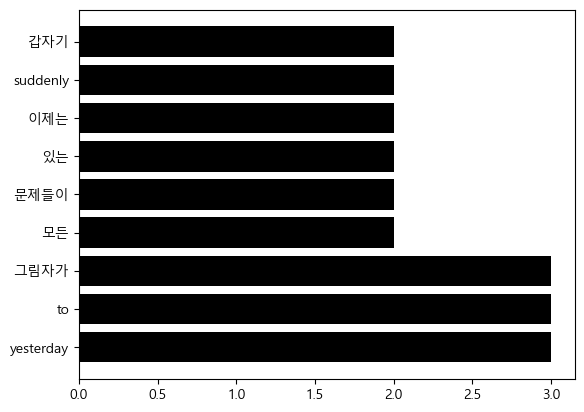

In [89]:
import matplotlib.pyplot as plt
#plt.rc('font', family='NanumMyeongjo')
plt.rcParams["font.family"] = "Malgun Gothic" 
plt.barh(range(len(v)), v, color = 'black')  # x <- from (v)alues
plt.yticks(range(len(v)), k)                 # y <- from (k)eys
plt.show()